# Load Packages

In [1]:
# imports for data handling, plotting, and regression

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression



# Load IPC data with underlying FSI information


In [2]:
home  = 'C:\\Users\\ck24\\OneDrive - University of Illinois - Urbana\\Documents'
test_df = pd.read_csv(home + r'\ipc_consistency_paper\stores\ipc_df.csv')

## Prepocessing data for further analysis

In [3]:
# calculate 3+ for each indicator
ipc_3plus_map = {
    'FCS_3plus': ['FCS_ipc3', 'FCS_ipc45'],
    'hdds_3plus': ['hdds_ipc3', 'hdds_ipc45'],
    'rCSI_3plus': ['rCSI_ipc3', 'rCSI_ipc45'],
    'hhs_3plus': ['hhs_ipc3', 'hhs_ipc4', 'hhs_ipc5'],
    'lcs_3plus': ['lcs_ipc3', 'lcs_ipc45']
}

for new_col, cols in ipc_3plus_map.items():
    prefix = cols[0].split('_')[0]  # determines base indicator name
    check_cols = [t for t in test_df if t.startswith(f'{prefix}_ipc')]

    test_df[new_col] = test_df[cols].sum(axis=1)
    test_df[new_col] = np.where(~test_df[check_cols].notna().any(axis=1), np.nan, test_df[new_col])

# phase 3+ share
test_df['phase3_plus'] = (
    test_df['phase3_percent']
    + test_df['phase4_percent']
    + test_df['phase5_percent']
)

test_df['phase3_plus'].describe()


count    1849.000000
mean        0.320427
std         0.166968
min         0.000000
25%         0.200000
50%         0.300000
75%         0.450000
max         0.850000
Name: phase3_plus, dtype: float64

In [4]:
# calculate 4+ pop estimates for each indicator
ipc_4plus_map = {
    'FCS_4plus': ['FCS_ipc45'],
    'hdds_4plus': ['hdds_ipc45'],
    'rCSI_4plus': ['rCSI_ipc45'],
    'hhs_4plus': ['hhs_ipc4', 'hhs_ipc5'],
    'lcs_4plus': ['lcs_ipc45']
}

# Compute 4plus values and set to NaN if all related *_ipc values are missing
for new_col, cols in ipc_4plus_map.items():
    prefix = cols[0].split('_')[0]  # e.g., 'FCS' from 'FCS_ipc45'
    all_ipc_cols = [c for c in test_df.columns if c.startswith(f'{prefix}_ipc')]

    # Sum only over defined 4plus columns
    test_df[new_col] = test_df[cols].sum(axis=1)

    # Set to NaN if *all* indicator-related ipc values are NaN
    test_df[new_col] = np.where(~test_df[all_ipc_cols].notna().any(axis=1), np.nan, test_df[new_col])

# Phase 4+ total
test_df['phase4_plus'] = test_df['phase4_percent'] + test_df['phase5_percent']
test_df['phase4_plus'].describe()

count    1849.000000
mean        0.079859
std         0.073070
min         0.000000
25%         0.050000
50%         0.050000
75%         0.100000
max         0.550000
Name: phase4_plus, dtype: float64

In [5]:
# indicator prefixes
indicators = ['FCS', 'rCSI', 'hhs', 'lcs', 'hdds']

# IPC phase-level indicator sets
ipc_levels = {
    'ipc_class1_set': ['FCS_ipc12', 'rCSI_ipc1', 'hhs_ipc1', 'lcs_ipc1', 'hdds_ipc12'],
    'ipc_class2_set': ['FCS_ipc12', 'rCSI_ipc2', 'hhs_ipc2', 'lcs_ipc2', 'hdds_ipc12'],
    'ipc_class3_set': [f'{ind}_ipc3' for ind in indicators],
    'ipc_class4_set': [f'{ind}_ipc45' if ind != 'hhs' else 'hhs_ipc4' for ind in indicators],
    'ipc_class5_set': [f'{ind}_ipc45' if ind != 'hhs' else 'hhs_ipc5' for ind in indicators],
}

# IPC 3+ and 4+ sets
ipc_plus_sets = {
    'ipc_class3_plus_set': ['phase3_plus'] + [f'{ind}_3plus' for ind in indicators],
    'ipc_class4_plus_set': ['phase4_plus'] + [f'{ind}_4plus' for ind in indicators]
}

# drop-one 3+ sets
drop_one_3plus_sets = {
    f'no{ind.lower()}_set3': [f'{i}_3plus' for i in indicators if i != ind] 
    for ind in indicators
}

# drop-one 4+ sets
drop_one_4plus_sets = {
    f'no{ind.lower()}_set4': [f'{i}_4plus' for i in indicators if i != ind] 
    for ind in indicators
}

# Merge all sets if needed
all_sets = {**ipc_levels, **ipc_plus_sets, **drop_one_3plus_sets, **drop_one_4plus_sets}
all_sets

{'ipc_class1_set': ['FCS_ipc12',
  'rCSI_ipc1',
  'hhs_ipc1',
  'lcs_ipc1',
  'hdds_ipc12'],
 'ipc_class2_set': ['FCS_ipc12',
  'rCSI_ipc2',
  'hhs_ipc2',
  'lcs_ipc2',
  'hdds_ipc12'],
 'ipc_class3_set': ['FCS_ipc3',
  'rCSI_ipc3',
  'hhs_ipc3',
  'lcs_ipc3',
  'hdds_ipc3'],
 'ipc_class4_set': ['FCS_ipc45',
  'rCSI_ipc45',
  'hhs_ipc4',
  'lcs_ipc45',
  'hdds_ipc45'],
 'ipc_class5_set': ['FCS_ipc45',
  'rCSI_ipc45',
  'hhs_ipc5',
  'lcs_ipc45',
  'hdds_ipc45'],
 'ipc_class3_plus_set': ['phase3_plus',
  'FCS_3plus',
  'rCSI_3plus',
  'hhs_3plus',
  'lcs_3plus',
  'hdds_3plus'],
 'ipc_class4_plus_set': ['phase4_plus',
  'FCS_4plus',
  'rCSI_4plus',
  'hhs_4plus',
  'lcs_4plus',
  'hdds_4plus'],
 'nofcs_set3': ['rCSI_3plus', 'hhs_3plus', 'lcs_3plus', 'hdds_3plus'],
 'norcsi_set3': ['FCS_3plus', 'hhs_3plus', 'lcs_3plus', 'hdds_3plus'],
 'nohhs_set3': ['FCS_3plus', 'rCSI_3plus', 'lcs_3plus', 'hdds_3plus'],
 'nolcs_set3': ['FCS_3plus', 'rCSI_3plus', 'hhs_3plus', 'hdds_3plus'],
 'nohdds_set3

In [6]:
# Compute averages for selected indicator sets (excluding 'phase3_plus' and 'phase4_plus')
average_targets = {
    'average_3plus': 'ipc_class3_plus_set',
    'no_fcs_3plus': 'nofcs_set3',
    'no_rcsi_3plus': 'norcsi_set3',
    'no_hhs_3plus': 'nohhs_set3',
    'no_lcs_3plus': 'nolcs_set3',
    'no_hdds_3plus': 'nohdds_set3',
    'average_4plus': 'ipc_class4_plus_set',
    'no_fcs_4plus': 'nofcs_set4',
    'no_rcsi_4plus': 'norcsi_set4',
    'no_hhs_4plus': 'nohhs_set4',
    'no_lcs_4plus': 'nolcs_set4',
    'no_hdds_4plus': 'nohdds_set4'
}

for new_col, set_name in average_targets.items():
    base_columns = all_sets[set_name]
    
    # Drop 'phase3_plus' or 'phase4_plus' if present, since it's not an indicator
    cols_to_use = [col for col in base_columns if not col.startswith('phase')]
    
    test_df[new_col] = test_df[cols_to_use].mean(axis=1)
    print(f"{new_col} is based on {cols_to_use}")


average_3plus is based on ['FCS_3plus', 'rCSI_3plus', 'hhs_3plus', 'lcs_3plus', 'hdds_3plus']
no_fcs_3plus is based on ['rCSI_3plus', 'hhs_3plus', 'lcs_3plus', 'hdds_3plus']
no_rcsi_3plus is based on ['FCS_3plus', 'hhs_3plus', 'lcs_3plus', 'hdds_3plus']
no_hhs_3plus is based on ['FCS_3plus', 'rCSI_3plus', 'lcs_3plus', 'hdds_3plus']
no_lcs_3plus is based on ['FCS_3plus', 'rCSI_3plus', 'hhs_3plus', 'hdds_3plus']
no_hdds_3plus is based on ['FCS_3plus', 'rCSI_3plus', 'hhs_3plus', 'lcs_3plus']
average_4plus is based on ['FCS_4plus', 'rCSI_4plus', 'hhs_4plus', 'lcs_4plus', 'hdds_4plus']
no_fcs_4plus is based on ['rCSI_4plus', 'hhs_4plus', 'lcs_4plus', 'hdds_4plus']
no_rcsi_4plus is based on ['FCS_4plus', 'hhs_4plus', 'lcs_4plus', 'hdds_4plus']
no_hhs_4plus is based on ['FCS_4plus', 'rCSI_4plus', 'lcs_4plus', 'hdds_4plus']
no_lcs_4plus is based on ['FCS_4plus', 'rCSI_4plus', 'hhs_4plus', 'hdds_4plus']
no_hdds_4plus is based on ['FCS_4plus', 'rCSI_4plus', 'hhs_4plus', 'lcs_4plus']


In [7]:
# define rounding function (5% nearest)
def round_to_nearest_5(x):
    if pd.isna(x):
        return np.nan
    return round(x * 100 / 5) * 5 / 100

# define all columns to apply rounding
round_columns = [
    # 3+ and 4+ phase & indicators
    'phase3_plus', 'FCS_3plus', 'rCSI_3plus', 'hhs_3plus', 'lcs_3plus', 'hdds_3plus',
    'phase4_plus', 'FCS_4plus', 'rCSI_4plus', 'hhs_4plus', 'lcs_4plus', 'hdds_4plus',
    
    # 3+ averages excluding one indicator
    'average_3plus', 'no_fcs_3plus', 'no_rcsi_3plus', 'no_hhs_3plus', 
    'no_lcs_3plus', 'no_hdds_3plus',
    
    # 4+ averages excluding one indicator
    'average_4plus', 'no_fcs_4plus', 'no_rcsi_4plus', 'no_hhs_4plus', 
    'no_lcs_4plus', 'no_hdds_4plus',
    
]

# apply rounding 5%
for col in round_columns:
    new_col = f"{col}_up"
    test_df[new_col] = test_df[col].apply(round_to_nearest_5)
    print(f"{new_col} based on {col}")

# collect all new `_up` columns
ipc_class34_plus_set_up = [col for col in test_df.columns if col.endswith('_up')]

print('Unique IPC TWG analyses')
# show result
for i in ipc_class34_plus_set_up[:6]:
    print('\n', i, test_df[test_df[i].notna()]['index'].nunique())


phase3_plus_up based on phase3_plus
FCS_3plus_up based on FCS_3plus
rCSI_3plus_up based on rCSI_3plus
hhs_3plus_up based on hhs_3plus
lcs_3plus_up based on lcs_3plus
hdds_3plus_up based on hdds_3plus
phase4_plus_up based on phase4_plus
FCS_4plus_up based on FCS_4plus
rCSI_4plus_up based on rCSI_4plus
hhs_4plus_up based on hhs_4plus
lcs_4plus_up based on lcs_4plus
hdds_4plus_up based on hdds_4plus
average_3plus_up based on average_3plus
no_fcs_3plus_up based on no_fcs_3plus
no_rcsi_3plus_up based on no_rcsi_3plus
no_hhs_3plus_up based on no_hhs_3plus
no_lcs_3plus_up based on no_lcs_3plus
no_hdds_3plus_up based on no_hdds_3plus
average_4plus_up based on average_4plus
no_fcs_4plus_up based on no_fcs_4plus
no_rcsi_4plus_up based on no_rcsi_4plus
no_hhs_4plus_up based on no_hhs_4plus
no_lcs_4plus_up based on no_lcs_4plus
no_hdds_4plus_up based on no_hdds_4plus
Unique IPC TWG analyses

 phase3_plus_up 27

 FCS_3plus_up 27

 rCSI_3plus_up 27

 hhs_3plus_up 17

 lcs_3plus_up 27

 hdds_3plus_up

## Comparison in FSI based Classification


In [8]:
# get all FCS_ipc columns sorted by phase to ensure correct order
fcs_cols = sorted([col for col in test_df.columns if col.startswith('FCS_ipc')])

# define helper sums ahead of time (to avoid redundant computation)
sum_last_2 = test_df[fcs_cols[-2:]].sum(axis=1)
sum_last_3 = test_df[fcs_cols[-3:]].sum(axis=1)

print(fcs_cols[-2:], fcs_cols[-3:])

# define conditions using precomputed values
conditions = [
    test_df[fcs_cols[-1]] >= 0.2,
    (test_df[fcs_cols[-1]] < 0.2) & (sum_last_2 >= 0.2),
    (test_df[fcs_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 >= 0.2)
]
choices = [4, 3, 2]

# assign FCS_class
test_df["FCS_class"] = np.select(conditions, choices, default=np.nan)

# check results
print(test_df['FCS_class'].value_counts().sort_index())


['FCS_ipc3', 'FCS_ipc45'] ['FCS_ipc12', 'FCS_ipc3', 'FCS_ipc45']
2.0    388
3.0    738
4.0    697
Name: FCS_class, dtype: int64


In [9]:
# get all rCSI_ipc columns sorted by phase to ensure correct order)
rcsi_cols = sorted([col for col in test_df.columns if col.startswith('rCSI_ipc')])

# precompute cumulative sums to avoid redundancy
sum_last_2 = test_df[rcsi_cols[-2:]].sum(axis=1)
sum_last_3 = test_df[rcsi_cols[-3:]].sum(axis=1)
sum_last_4 = test_df[rcsi_cols[-4:]].sum(axis=1)

print("Last 2 rCSI cols:", rcsi_cols[-2:])
print("Last 3 rCSI cols:", rcsi_cols[-3:])
print("Last 4 rCSI cols:", rcsi_cols[-4:])

# define conditions using the precomputed sums
conditions = [
    test_df[rcsi_cols[-1]] >= 0.2,
    (test_df[rcsi_cols[-1]] < 0.2) & (sum_last_2 >= 0.2),
    (test_df[rcsi_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 >= 0.2),
    (test_df[rcsi_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 < 0.2) & (sum_last_4 >= 0.2)
]
choices = [4, 3, 2, 1]

# assign rCSI_class
test_df["rCSI_class"] = np.select(conditions, choices, default=np.nan)

# check results
print(test_df['rCSI_class'].value_counts().sort_index())


Last 2 rCSI cols: ['rCSI_ipc3', 'rCSI_ipc45']
Last 3 rCSI cols: ['rCSI_ipc2', 'rCSI_ipc3', 'rCSI_ipc45']
Last 4 rCSI cols: ['rCSI_ipc1', 'rCSI_ipc2', 'rCSI_ipc3', 'rCSI_ipc45']
1.0    206
2.0    886
3.0    722
4.0      1
Name: rCSI_class, dtype: int64


In [10]:
# get all lcs_ipc columns sorted by phase (ensure correct order)
lcs_cols = sorted([col for col in test_df.columns if col.startswith('lcs_ipc')])

# precompute cumulative sums to avoid redundant computation
sum_last_1 = test_df[lcs_cols[-1:]].sum(axis=1)
sum_last_2 = test_df[lcs_cols[-2:]].sum(axis=1)
sum_last_3 = test_df[lcs_cols[-3:]].sum(axis=1)
sum_last_4 = test_df[lcs_cols[-4:]].sum(axis=1)

print("Last 1 lcs cols:", lcs_cols[-1:])
print("Last 2 lcs cols:", lcs_cols[-2:])
print("Last 3 lcs cols:", lcs_cols[-3:])
print("Last 4 lcs cols:", lcs_cols[-4:])

# define conditions
conditions = [
    test_df[lcs_cols[-1]] >= 0.2,
    (test_df[lcs_cols[-1]] < 0.2) & (sum_last_2 >= 0.2),
    (test_df[lcs_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 >= 0.2),
    (test_df[lcs_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 < 0.2) & (sum_last_4 >= 0.2)
]
choices = [4, 3, 2, 1]

# assign lcs_class
test_df["lcs_class"] = np.select(conditions, choices, default=np.nan)

# check results
print(test_df['lcs_class'].value_counts().sort_index())


Last 1 lcs cols: ['lcs_ipc45']
Last 2 lcs cols: ['lcs_ipc3', 'lcs_ipc45']
Last 3 lcs cols: ['lcs_ipc2', 'lcs_ipc3', 'lcs_ipc45']
Last 4 lcs cols: ['lcs_ipc1', 'lcs_ipc2', 'lcs_ipc3', 'lcs_ipc45']
1.0     58
2.0    152
3.0    870
4.0    744
Name: lcs_class, dtype: int64


In [11]:
# get all hdds_ipc columns sorted by phase
hdds_cols = sorted([col for col in test_df.columns if col.startswith('hdds_ipc')])

# precompute cumulative sums
sum_last_1 = test_df[hdds_cols[-1:]].sum(axis=1)
sum_last_2 = test_df[hdds_cols[-2:]].sum(axis=1)
sum_last_3 = test_df[hdds_cols[-3:]].sum(axis=1)

print("Last 1 hdds cols:", hdds_cols[-1:])
print("Last 2 hdds cols:", hdds_cols[-2:])
print("Last 3 hdds cols:", hdds_cols[-3:])

# define conditions
conditions = [
    test_df[hdds_cols[-1]] >= 0.2,
    (test_df[hdds_cols[-1]] < 0.2) & (sum_last_2 >= 0.2),
    (test_df[hdds_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 >= 0.2)
]
choices = [4, 3, 2]

# assign hdds_class
test_df["hdds_class"] = np.select(conditions, choices, default=np.nan)

# check results
print(test_df['hdds_class'].value_counts().sort_index())


Last 1 hdds cols: ['hdds_ipc45']
Last 2 hdds cols: ['hdds_ipc3', 'hdds_ipc45']
Last 3 hdds cols: ['hdds_ipc12', 'hdds_ipc3', 'hdds_ipc45']
2.0    261
3.0    412
4.0    221
Name: hdds_class, dtype: int64


In [12]:
# get all hhs_ipc columns sorted by phase (ensure order is correct)
hhs_cols = sorted([col for col in test_df.columns if col.startswith('hhs_ipc')])

# precompute cumulative sums for last 2–5 columns
sum_last_2 = test_df[hhs_cols[-2:]].sum(axis=1)
sum_last_3 = test_df[hhs_cols[-3:]].sum(axis=1)
sum_last_4 = test_df[hhs_cols[-4:]].sum(axis=1)
sum_last_5 = test_df[hhs_cols[-5:]].sum(axis=1)

print("Last 2 hhs cols:", hhs_cols[-2:])
print("Last 3 hhs cols:", hhs_cols[-3:])
print("Last 4 hhs cols:", hhs_cols[-4:])
print("Last 5 hhs cols:", hhs_cols[-5:])

# define conditions in descending order of severity
conditions = [
    test_df[hhs_cols[-1]] >= 0.2,
    (test_df[hhs_cols[-1]] < 0.2) & (sum_last_2 >= 0.2),
    (test_df[hhs_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 >= 0.2),
    (test_df[hhs_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 < 0.2) & (sum_last_4 >= 0.2),
    (test_df[hhs_cols[-1]] < 0.2) & (sum_last_2 < 0.2) & (sum_last_3 < 0.2) & (sum_last_4 < 0.2) & (sum_last_5 >= 0.2)
]
choices = [5, 4, 3, 2, 1]

# assign hhs_class
test_df["hhs_class"] = np.select(conditions, choices, default=np.nan)

# check results
print(test_df['hhs_class'].value_counts().sort_index())


Last 2 hhs cols: ['hhs_ipc4', 'hhs_ipc5']
Last 3 hhs cols: ['hhs_ipc3', 'hhs_ipc4', 'hhs_ipc5']
Last 4 hhs cols: ['hhs_ipc2', 'hhs_ipc3', 'hhs_ipc4', 'hhs_ipc5']
Last 5 hhs cols: ['hhs_ipc1', 'hhs_ipc2', 'hhs_ipc3', 'hhs_ipc4', 'hhs_ipc5']
1.0     53
2.0    129
3.0    793
4.0     85
5.0     13
Name: hhs_class, dtype: int64


### Class Difference

In [13]:
# select all *_class columns
class_cols = [col for col in test_df.columns if col.endswith('_class')]
print(class_cols)
# compute min, max, and range across *_class columns
test_df['class_MIN'] = test_df[class_cols].min(axis=1)
test_df['class_MAX'] = test_df[class_cols].max(axis=1)
test_df['class_range'] = test_df['class_MAX'] - test_df['class_MIN']


# print normalized value counts by phase
print(
    test_df.groupby('overall_phase')['class_range']
    .value_counts(normalize=True)
    .sort_index()
    .round(3)
)

# display diagnostic columns
display_cols = ['overall_phase', 'class_MIN', 'class_MAX', 'class_range'] + class_cols
test_df[display_cols]


['FCS_class', 'rCSI_class', 'lcs_class', 'hdds_class', 'hhs_class']
overall_phase  class_range
1.0            0.0            0.067
               1.0            0.733
               2.0            0.200
2.0            0.0            0.065
               1.0            0.489
               2.0            0.390
               3.0            0.056
3.0            0.0            0.051
               1.0            0.489
               2.0            0.413
               3.0            0.048
4.0            0.0            0.031
               1.0            0.702
               2.0            0.257
               3.0            0.010
Name: class_range, dtype: float64


,overall_phase,class_MIN,class_MAX,class_range,FCS_class,rCSI_class,lcs_class,hdds_class,hhs_class
0,3.0,3.0,4.0,1.0,4.0,3.0,4.0,3.0,3.0
1,3.0,3.0,4.0,1.0,4.0,3.0,4.0,3.0,3.0
2,3.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
3,3.0,2.0,4.0,2.0,3.0,3.0,4.0,3.0,2.0
4,3.0,3.0,4.0,1.0,3.0,3.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...
1844,2.0,1.0,3.0,2.0,3.0,1.0,2.0,NaN,NaN
1845,3.0,1.0,3.0,2.0,3.0,1.0,2.0,NaN,NaN
1846,3.0,2.0,3.0,1.0,3.0,2.0,3.0,NaN,NaN
1847,3.0,2.0,2.0,0.0,2.0,2.0,2.0,NaN,NaN


# Table 1. Summary of cases and FSI availability in IPC analyses

### FSI Group & relevant FSI matcher

In [14]:
# Easy Subset - Phase 3
print(set(test_df['FSI_combination'].unique()))

combi_match = {'FCS-RCSI-HHS-LCS'    : ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up',                ],
             'FCS-RCSI-HHS-LCS-HDDS' : ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'],
             'FCS-RCSI-LCS'          : ['FCS_3plus_up', 'rCSI_3plus_up',                 'lcs_3plus_up',                ],
             'FCS-RCSI-LCS-HDDS'     : ['FCS_3plus_up', 'rCSI_3plus_up',                 'lcs_3plus_up', 'hdds_3plus_up']}

{'FCS-RCSI-HHS-LCS', 'FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS'}


In [15]:
# Easy Subset - Phase 4
print(set(test_df['FSI_combination'].unique()))

combi_match4 = {'FCS-RCSI-HHS-LCS'   : ['FCS_4plus_up', 'rCSI_4plus_up', 'hhs_4plus_up', 'lcs_4plus_up',                ],
             'FCS-RCSI-HHS-LCS-HDDS' : ['FCS_4plus_up', 'rCSI_4plus_up', 'hhs_4plus_up', 'lcs_4plus_up', 'hdds_4plus_up'],
             'FCS-RCSI-LCS'          : ['FCS_4plus_up', 'rCSI_4plus_up',                 'lcs_4plus_up',                ],
             'FCS-RCSI-LCS-HDDS'     : ['FCS_4plus_up', 'rCSI_4plus_up',                 'lcs_4plus_up', 'hdds_4plus_up']}

{'FCS-RCSI-HHS-LCS', 'FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-LCS-HDDS', 'FCS-RCSI-LCS'}


## Sample A

In [16]:
# Sample A
print('Sample A FSI available obs:\n', len(test_df) - test_df[['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']].isna().sum())

Sample A FSI available obs:
 FCS_3plus_up     1825
rCSI_3plus_up    1815
hhs_3plus_up     1073
lcs_3plus_up     1825
hdds_3plus_up     898
dtype: int64


## Sample B

In [17]:
add_df = []
for i in test_df['FSI_combination'].unique():
    sub_df = test_df[test_df['FSI_combination']==i].dropna(subset = combi_match[i])
    add_df.append(sub_df)
    
    
print('Sample B FSI available obs:\n', len(pd.concat(add_df)) - pd.concat(add_df)[['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']].isna().sum())

Sample B FSI available obs:
 FCS_3plus_up     1693
rCSI_3plus_up    1693
hhs_3plus_up      991
lcs_3plus_up     1693
hdds_3plus_up     862
dtype: int64


## Disaggregation of Sample B By Data Group

In [18]:
for i in test_df['FSI_combination'].unique():
    sub_df = test_df[test_df['FSI_combination']==i]
    print(f'Sample B By Data Group: {i} --', len(sub_df.dropna(subset = combi_match[i])))
    print(len(sub_df.dropna(subset = combi_match[i]))-sub_df.dropna(subset = combi_match[i])[['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']].isna().sum())

Sample B By Data Group: FCS-RCSI-HHS-LCS-HDDS -- 600
FCS_3plus_up     600
rCSI_3plus_up    600
hhs_3plus_up     600
lcs_3plus_up     600
hdds_3plus_up    600
dtype: int64
Sample B By Data Group: FCS-RCSI-HHS-LCS -- 360
FCS_3plus_up     360
rCSI_3plus_up    360
hhs_3plus_up     360
lcs_3plus_up     360
hdds_3plus_up      0
dtype: int64
Sample B By Data Group: FCS-RCSI-LCS-HDDS -- 236
FCS_3plus_up     236
rCSI_3plus_up    236
hhs_3plus_up      31
lcs_3plus_up     236
hdds_3plus_up    236
dtype: int64
Sample B By Data Group: FCS-RCSI-LCS -- 497
FCS_3plus_up     497
rCSI_3plus_up    497
hhs_3plus_up       0
lcs_3plus_up     497
hdds_3plus_up     26
dtype: int64


In [19]:
append_df = []

# iterate through each fsi combination and drop rows with missing required indicators
for comb in test_df['FSI_combination'].unique():
    sdf = test_df[test_df['FSI_combination'] == comb]
    sdf = sdf.dropna(subset=combi_match[comb])
    append_df.append(sdf)

# keep full df for reference
total_df = test_df.copy()

# concatenate valid entries for statistical analysis (n = 1693)
stat_df = pd.concat(append_df, ignore_index=True)

for col in ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']:
    print(stat_df.groupby('FSI_combination')[col].count().sort_index())

# count non-missing values for key indicators by index
key_indicators = ['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']
availability_tab = stat_df.groupby('index')[key_indicators].count().reset_index()

# count total number of observations per index
availability_tab['obs'] = stat_df.groupby('index')['index'].count().values

# keep copies for reference
availability_tab['no_phase_obs'] = availability_tab['obs']
availability_tab['original_obs'] = availability_tab['obs']

# generate dummy flags: 1 if > 50% non-missing, else np.nan
for col in key_indicators:
    availability_tab[f'{col}_d'] = np.where(
        availability_tab[col] / availability_tab['obs'] > 0.5, 1, np.nan
    )

# count how many of the 5 key indicators meet the > 50% availability criterion
availability_tab['num_available_FSI'] = availability_tab[
    [f'{col}_d' for col in key_indicators]
].sum(axis=1)

# sort for summary
availability_tab_sorted = availability_tab.sort_values('index')

print("total unique twg indices:", len(availability_tab))

d_cols = [c for c in availability_tab_sorted.columns if c.endswith('_d')][:5]

print("per-indicator unique twg analyses:")
print(availability_tab_sorted[d_cols].sum())


FSI_combination
FCS-RCSI-HHS-LCS         360
FCS-RCSI-HHS-LCS-HDDS    600
FCS-RCSI-LCS             497
FCS-RCSI-LCS-HDDS        236
Name: FCS_3plus_up, dtype: int64
FSI_combination
FCS-RCSI-HHS-LCS         360
FCS-RCSI-HHS-LCS-HDDS    600
FCS-RCSI-LCS             497
FCS-RCSI-LCS-HDDS        236
Name: rCSI_3plus_up, dtype: int64
FSI_combination
FCS-RCSI-HHS-LCS         360
FCS-RCSI-HHS-LCS-HDDS    600
FCS-RCSI-LCS               0
FCS-RCSI-LCS-HDDS         31
Name: hhs_3plus_up, dtype: int64
FSI_combination
FCS-RCSI-HHS-LCS         360
FCS-RCSI-HHS-LCS-HDDS    600
FCS-RCSI-LCS             497
FCS-RCSI-LCS-HDDS        236
Name: lcs_3plus_up, dtype: int64
FSI_combination
FCS-RCSI-HHS-LCS           0
FCS-RCSI-HHS-LCS-HDDS    600
FCS-RCSI-LCS              26
FCS-RCSI-LCS-HDDS        236
Name: hdds_3plus_up, dtype: int64
total unique twg indices: 27
per-indicator unique twg analyses:
FCS_3plus_up_d     27.0
rCSI_3plus_up_d    27.0
hhs_3plus_up_d     16.0
lcs_3plus_up_d     27.0
hdds_3plus_up

# Figure 1. Distribution of consensus-based phase classifcations

Phase 1      15
Phase 2     446
Phase 3    1192
Phase 4     196
Name: overall_phase_re, dtype: int64
Total Observations: 1849


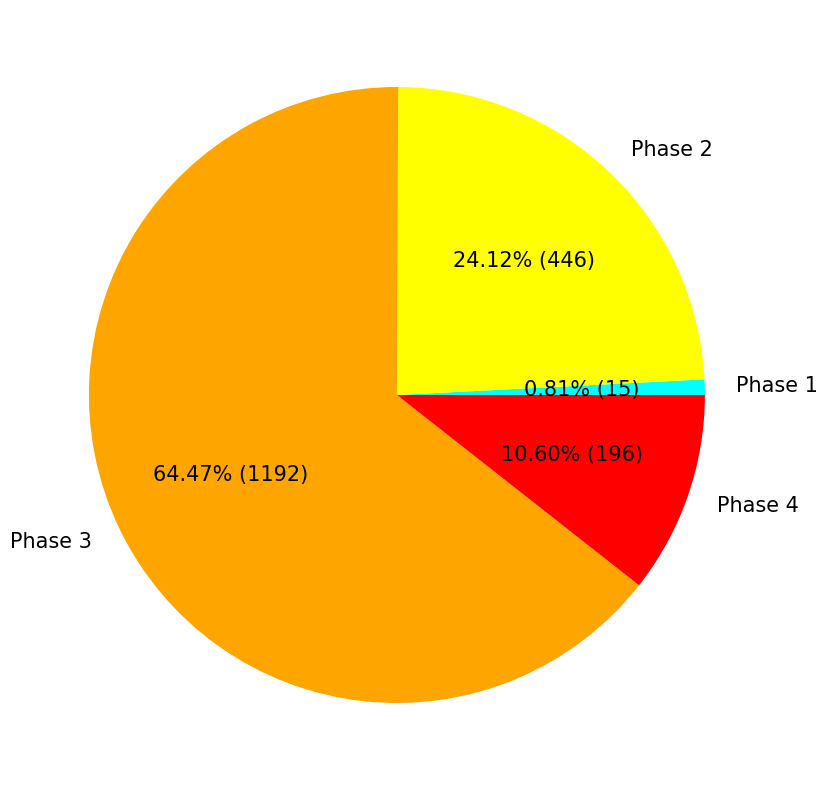

In [20]:
# format phase labels
test_df['overall_phase_re'] = ['Phase ' + str(int(t)) for t in test_df['overall_phase']]

# get actual counts (not proportions)
phase_counts = test_df['overall_phase_re'].value_counts().sort_index()
print(phase_counts)
print('Total Observations:', phase_counts.sum())
phase_labels = phase_counts.index.tolist()
colors = ['aqua', 'yellow', 'orange', 'red'][:len(phase_labels)]

# custom label function using actual counts
def make_autopct(counts):
    def autopct(pct):
        total = sum(counts)
        count = int(round(pct * total / 100.0))
        return f'{pct:.2f}% ({count})'
    return autopct

# plot pie chart
plt.figure(figsize=(15, 10))
plt.pie(
    phase_counts,
    labels=phase_labels,
    colors=colors,
    autopct=make_autopct(phase_counts),
    textprops={'fontsize': 15}
)
#plt.title("Distribution of consensus-based phase classfications", fontsize=18)
plt.show()


# Figure 2. Pairwise Relationships and OLS Regression Coefficients Among FSI Implied 3+ Population (%) for Sample with All-5-FSI

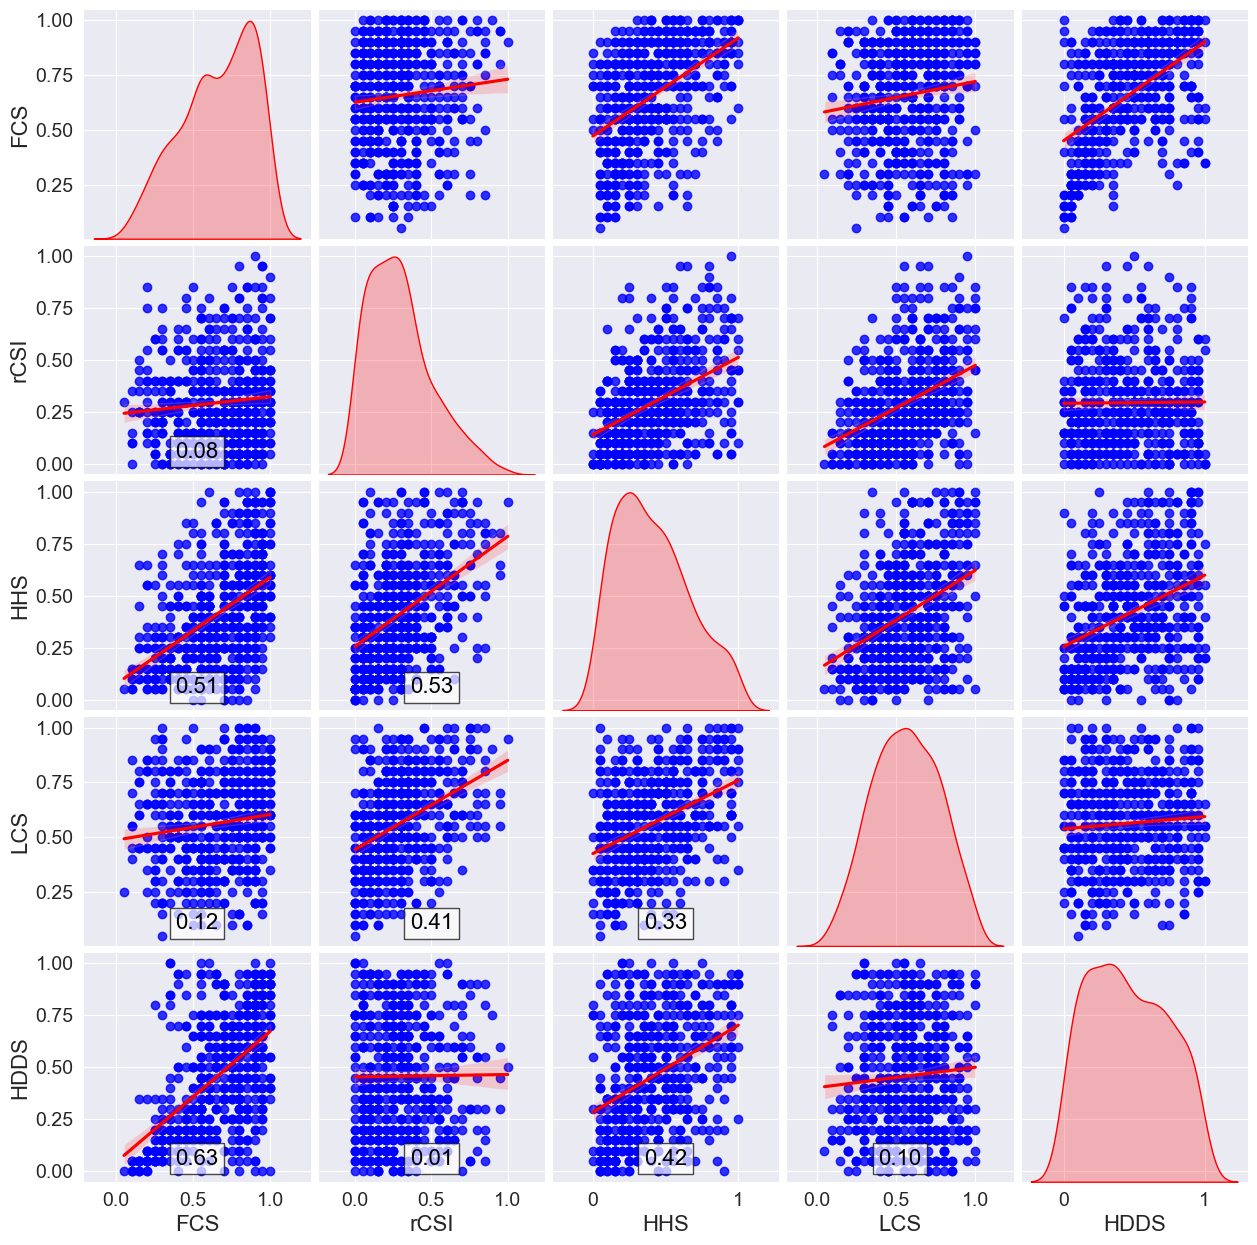

In [21]:
# Set Seaborn style
sns.set_style('darkgrid')

# create test_df copy
test_df_sub = test_df.copy()

# define custom labels for the axes
custom_labels = ['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS']
fsi_combi = test_df_sub['FSI_combination'].unique()[0]
plot_vars = combi_match[fsi_combi]

# drop NAs to run regression
reg_df = test_df_sub[test_df_sub['FSI_combination'] == fsi_combi].dropna(subset=plot_vars).round(2)
cleaned_df = reg_df[plot_vars]

# create pairplot with regression plots and KDE on the diagonal
g = sns.pairplot(
    data=cleaned_df, 
    kind='reg', 
    diag_kind='kde', 
    diag_kws={'color': 'red'},
    plot_kws={
        'line_kws': {'color': 'red'}, 
        'scatter_kws': {'color': 'blue'}
    }
)

# annotate regression slope coefficient
def annotate_slope(x, y, ax):
    mask = np.isfinite(x) & np.isfinite(y)  # drop NaNs
    if mask.sum() > 1:  # need at least 2 points
        model = LinearRegression().fit(x[mask].values.reshape(-1, 1), y[mask].values)
        slope = model.coef_[0]
        ax.text(
            0.5, 0.1, f"{slope:.2f}", 
            fontsize=16, color='black', ha='center', va='center',
            transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
        )
# annotate regression slopes
for i in range(len(plot_vars)):
    for j in range(i):
        ax = g.axes[i, j]
        x = cleaned_df[plot_vars[j]]
        y = cleaned_df[plot_vars[i]]
        annotate_slope(x, y, ax)

# custom labels and increase font sizes for all axes
for i, label in enumerate(custom_labels):
    g.axes[i, 0].set_ylabel(label, fontsize=16)
    g.axes[-1, i].set_xlabel(label, fontsize=16)

# increase tick size 
for ax_row in g.axes:
    for ax in ax_row:
        if ax is not None:
            ax.tick_params(axis='both', labelsize=14)


plt.show()


# Figure 3. Consensus-based 3+ Population (%) for cases with 5 food security indicators

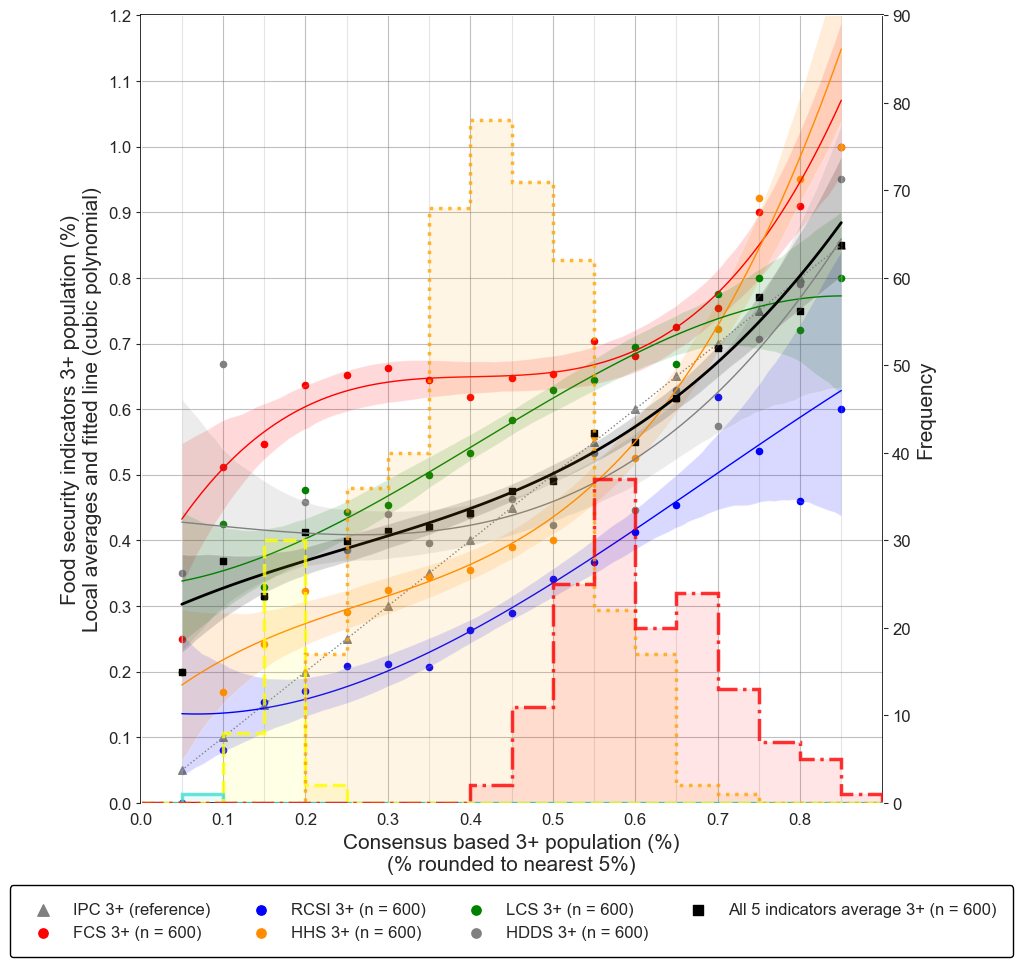

In [22]:
# reg helper
def reg_plot(data, x_var, y_var, label, color, ax):
    sns.regplot(
        data=data,
        x=x_var,
        y=y_var,
        label=label,
        order=3,
        truncate=True,
        dropna=True,
        color=color,
        line_kws={'linewidth': 1 if y_var != 'average3_up' else 2},
        x_estimator=np.mean,
        x_ci=None,
        ax=ax,
        scatter_kws={'s': 20}
    )

# plot parameters
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax1 = ax.twinx()

test_df_sub = test_df[(test_df['overall_phase'] >= 1) & (test_df['overall_phase'] <= 5)]
fsi_set = 'FCS-RCSI-HHS-LCS-HDDS'

df = test_df_sub[test_df_sub['FSI_combination'] == fsi_set]
df = df.dropna(subset=combi_match[fsi_set])

df['ipc_ym'] = df['ipc_period'].astype(str)
df['twg'] = df.set_index(['country', 'ipc_ym']).index
x_var = df['phase3_plus'].round(2)

# unique phases and colors
unique_phases = sorted(df['overall_phase'].unique())
phase_color_map = {1: 'turquoise', 2: 'yellow', 3: 'orange', 4: 'red', 5: 'darkred'}

# bin edges
bin_edges = np.arange(0, 1.0 + 0.049999, 0.049999)

# linestyles per phase
phase_linestyles = {
    1: 'solid',
    2: 'dashed',
    3: 'dotted',
    4: 'dashdot',
    5: (0, (3, 5, 1, 5))
}

# histograms by phase
for phase in unique_phases:
    subset_df = df[df['overall_phase'] == phase]
    if subset_df.empty:
        continue

    values = subset_df['phase3_plus_up'].dropna().clip(0, 1)

    ax1.hist(
        values,
        bins=bin_edges,
        color=phase_color_map[phase],
        stacked=True,
        alpha=0.1,
        linewidth=0,
        histtype="bar"
    )

    ax1.hist(
        values,
        bins=bin_edges,
        color=phase_color_map[phase],
        stacked=True,
        alpha=0.8,
        linewidth=2.5,
        histtype="step",
        linestyle=phase_linestyles.get(phase, "-")
    )

# ipc 3+ reference line
sns.regplot(
    data=df,
    x=x_var,
    y=x_var,
    label='IPC 3+ (reference)',
    order=3,
    truncate=True,
    dropna=True,
    color='gray',
    line_kws={'linewidth': 1, 'linestyle': ':'},
    x_estimator=np.mean,
    x_ci=95,
    ax=ax,
    marker='^',
    scatter_kws={'s': 30}
)

# fsi indicators
fsi_list = ['FCS', 'rCSI', 'hhs', 'lcs', 'hdds']
color_list = ['red', 'blue', 'darkorange', 'green', 'gray']

for fsi, color in zip(fsi_list, color_list):
    label = f'{fsi.upper()} 3+ (n = {len(df.dropna(subset=[f"{fsi}_3plus_up"]))})'
    reg_plot(df, x_var, f'{fsi}_3plus_up', label, color, ax)

# average of fsi based estimates
sns.regplot(
    data=df,
    x=x_var,
    y='average_3plus_up',
    label=f'All 5 indicators average 3+ (n = {len(df.dropna(subset=[t for t in df if "_3plus_up" in t][:5]))})',
    order=3,
    truncate=True,
    dropna=True,
    color='black',
    line_kws={'linewidth': 2, 'linestyle': '-'},
    x_estimator=np.mean,
    x_ci=None,
    ax=ax,
    marker='s',
    scatter_kws={'s': 20}
)

xy_lim_bottom = 0.0

# main axis appearance
ax.set_facecolor("white")
ax.set_xlim([xy_lim_bottom, 0.9])
ax.set_ylim([xy_lim_bottom, 1.2])

ax.set_xlabel(
    'Consensus based 3+ population (%)\n(% rounded to nearest 5%)',
    fontsize=15
)
ax.set_ylabel(
    'Food security indicators 3+ population (%)\nLocal averages and fitted line (cubic polynomial)',
    fontsize=15
)

ax.legend(
    fontsize=12,
    markerscale=1.5,
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    borderpad=1,
    loc='center',
    frameon=True,
    facecolor="white",
    edgecolor="black",
    framealpha=1.0
)

ax.set_xticks(np.arange(xy_lim_bottom, 0.9, 0.1))
ax.set_xticks(np.arange(xy_lim_bottom, 0.9, 0.05), minor=True)
ax.set_xticklabels(np.arange(xy_lim_bottom, 0.9, 0.1).round(2), fontsize=12)

ax.set_yticks(np.arange(xy_lim_bottom, 1.3, 0.1))
ax.set_yticks(np.arange(xy_lim_bottom, 1.3, 0.1), minor=True)
ax.set_yticklabels(np.arange(xy_lim_bottom, 1.3, 0.1).round(2), fontsize=12)

# border for main axis
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color("black")

# secondary axis
ax1.set_yticks(np.arange(0, 100, 10))
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylabel('Frequency', fontsize=15)
ax1.set_yticklabels(np.arange(0, 100, 10), fontsize=12)

ax.grid(which='both', color='gray')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax1.grid(False)

fig.tight_layout(rect=[0, 0.01, 1, 0.985])


## Figure 4 Histogram of all possible counterfactual consistent food insecurity phase classifications

In [23]:
import matplotlib.patches as mpatches

7429


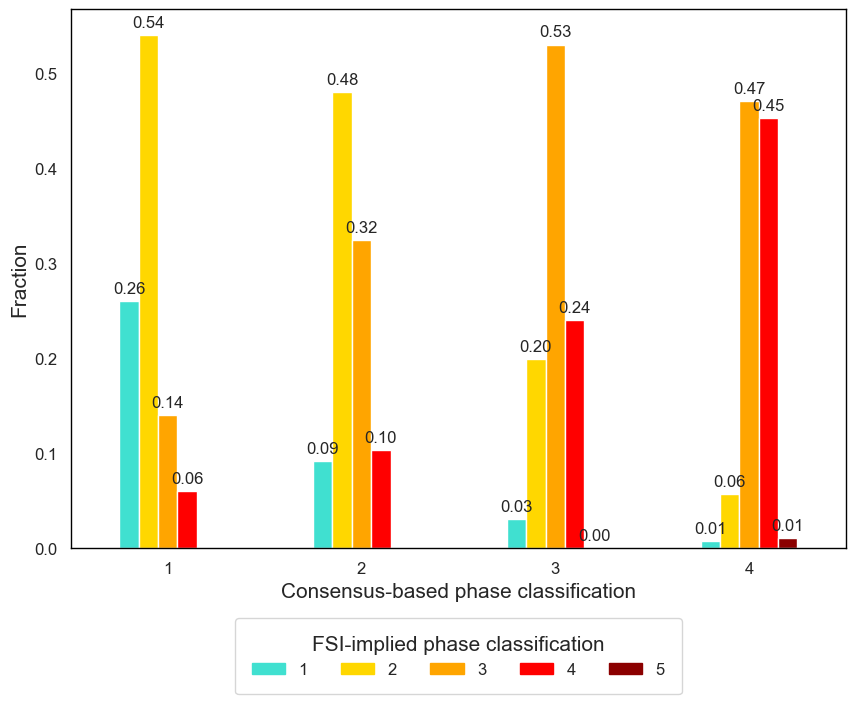

In [24]:
# filter data by specified fsi combinations
fsi_combinations = ['FCS-RCSI-HHS-LCS-HDDS', 'FCS-RCSI-LCS', 'FCS-RCSI-HHS-LCS', 'FCS-RCSI-LCS-HDDS']
df = test_df_sub[test_df_sub['FSI_combination'].isin(fsi_combinations)]
subdf = df[[col for col in df.columns if col.endswith('class')] + ['overall_phase', 'FSI_combination']]

# reshape data into long format
longitudinal_data = []
for _, row in subdf.iterrows():
    overall_phase = row['overall_phase']
    fsi_comb = row['FSI_combination']
    for indicator in ['FCS', 'rCSI', 'lcs', 'hdds', 'hhs']:
        value = row[f'{indicator}_class']
        if pd.notna(value):
            longitudinal_data.append({
                'overall_phase': overall_phase,
                'indicator': indicator,
                'value': value,
                'FSI_combination': fsi_comb
            })

long_df = pd.DataFrame(longitudinal_data)
print(len(long_df))

# set up plot
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(10, 7))

# define custom color palette for phases
custom_palette = {
    1: 'turquoise',
    2: 'gold',
    3: 'orange',
    4: 'red',
    5: 'darkred'
}

# group data and create bar plot of fractions
phase_fraction = (
    long_df
    .groupby('overall_phase')['value']
    .value_counts(normalize=True)
    .unstack()
)

ax = phase_fraction.plot(
    kind='bar',
    stacked=False,
    ax=ax,
    color=[custom_palette.get(i, 'gray') for i in range(1, 6)]
)

# white background
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# add black border around axes
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

# annotate fractions on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.005,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=12
        )

# manually define legend based on custom_palette
legend_patches = [
    mpatches.Patch(color=color, label=f'{phase}')
    for phase, color in custom_palette.items()
]
plt.legend(
    handles=legend_patches,
    title='FSI-implied phase classification',
    fontsize=12,
    title_fontsize=15,
    markerscale=1.5,
    bbox_to_anchor=(0.5, -0.2),
    ncol=5,
    borderpad=1,
    loc='center'
)

# customize axes
plt.xlabel('Consensus-based phase classification', fontsize=15)
plt.ylabel('Fraction', fontsize=15)

xticks_labels = ['1', '2', '3', '4']
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels, fontsize=12, rotation=0)
plt.tick_params(axis='y', labelsize=12)

plt.grid(False)
plt.show()


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Figure 5: Marginal Effects of Food Security Indicators on Phase 3+ Food Insecurity by Indicator Group

Note: This figure displays the marginal effects at the mean (dy/dx) from logistic regression models estimating the likelihood of households being in Phase 3 or above food insecurity (Phase 3+), stratified by four predefined groups of food security indicator combinations. Each panel represents one group, with effects plotted for each indicator used in the model. Point estimates (circles) are shown with 95% confidence intervals (bars). Positive values suggest that higher values of the indicator increase the probability of being classified as Phase 3+, whereas negative values suggest the opposite.

FCS-RCSI-HHS-LCS-HDDS
Optimization terminated successfully.
         Current function value: 0.644149
         Iterations 4
FCS-RCSI-HHS-LCS
Optimization terminated successfully.
         Current function value: 0.580934
         Iterations 5
FCS-RCSI-LCS-HDDS
Optimization terminated successfully.
         Current function value: 0.392468
         Iterations 6
FCS-RCSI-LCS
Optimization terminated successfully.
         Current function value: 0.381863
         Iterations 6


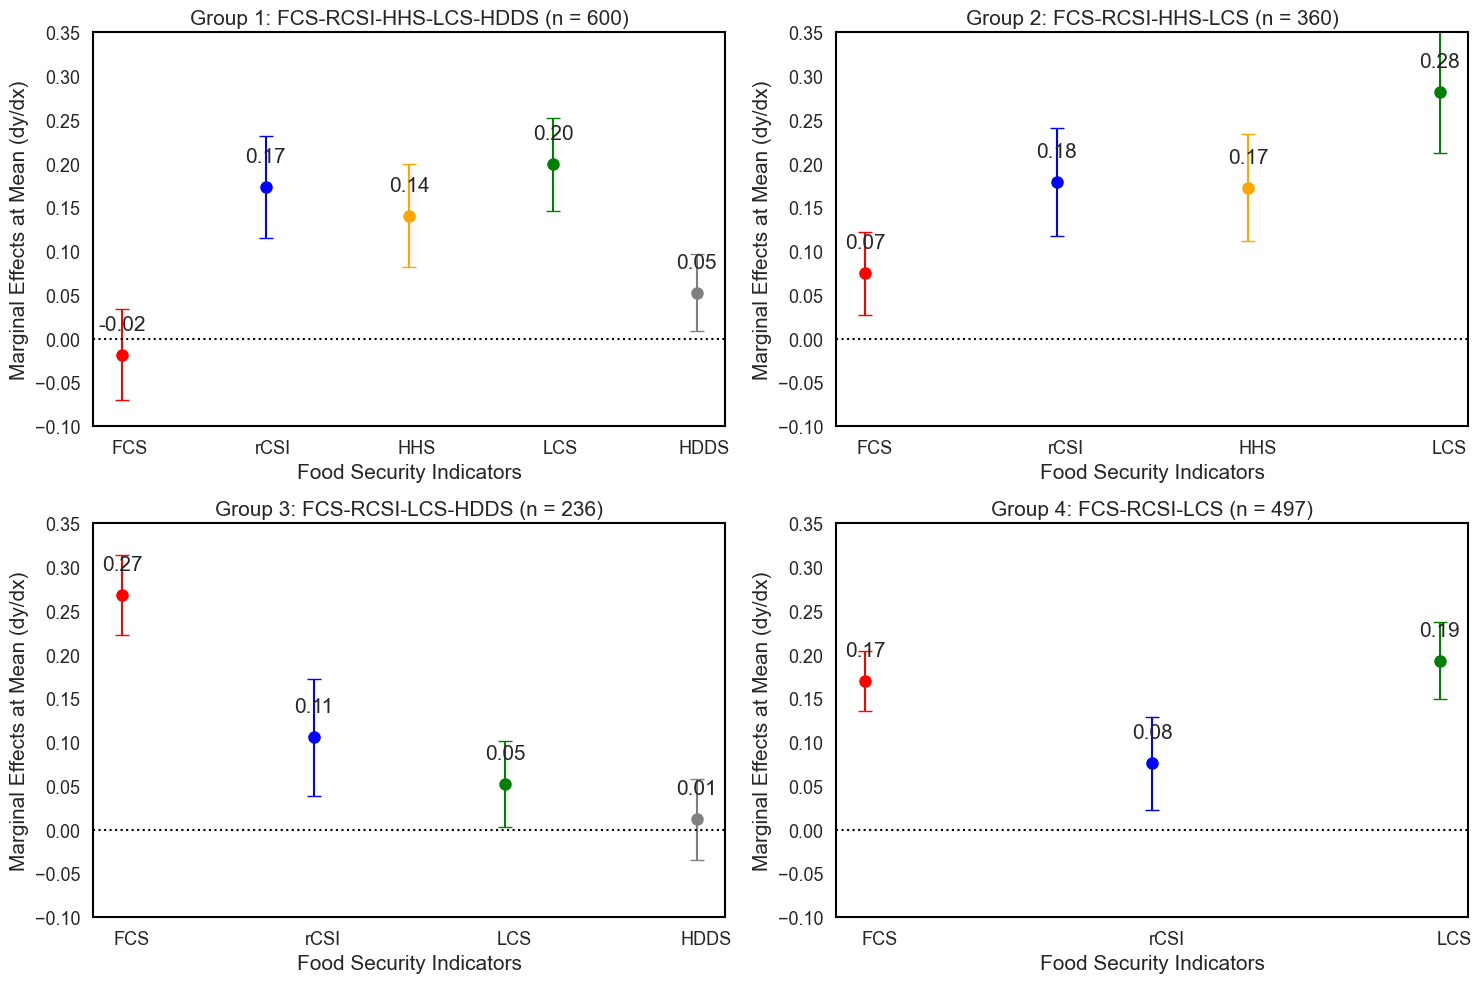

In [26]:
# Initialize figure for 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# map for color and labels
variable_display_map = {
    'FCS_3plus_up': ('FCS', 'red'),
    'rCSI_3plus_up': ('rCSI', 'blue'),
    'hhs_3plus_up': ('HHS', 'orange'),
    'lcs_3plus_up': ('LCS', 'green'),
    'hdds_3plus_up': ('HDDS', 'gray')
}

# loop through each FSI group
for num, fsi_combi in enumerate(test_df_sub['FSI_combination'].unique()):
    print(fsi_combi)
    
    # get predictor sets
    variables3 = combi_match[fsi_combi]
    variables4 = combi_match4[fsi_combi]

    # Phase 3+ Model (fractional logistic model)
    reg_df3 = test_df_sub[test_df_sub['FSI_combination'] == fsi_combi].dropna(subset=variables3 + ['phase3_plus_up'])
    y3 = reg_df3['phase3_plus_up']
    X3 = sm.add_constant(reg_df3[variables3])

    model3 = sm.Logit(y3, X3).fit(cov_type='HC1')
    margeff3 = model3.get_margeff(at='mean', method='dydx')
    me_df3 = margeff3.summary_frame()
    effects3 = me_df3['dy/dx'].values
    std_errs3 = me_df3['Std. Err.'].values

    # get color and label for each variable
    colors = [variable_display_map[var][1] for var in variables3]
    labels = [variable_display_map[var][0] for var in variables3]

    # Color and Label setup
    color_dict = {
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['red', 'blue', 'orange', 'green', 'gray'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'): ['red', 'blue', 'orange', 'green'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['red', 'blue', 'green', 'gray'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'): ['red', 'blue', 'green']
    }

    gca_dict = {
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'): ['FCS', 'rCSI', 'HHS', 'LCS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['FCS', 'rCSI', 'LCS', 'HDDS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'): ['FCS', 'rCSI', 'LCS']
    }

    colors = color_dict.get(tuple(variables3), ['red', 'blue', 'orange', 'green', 'gray'])
    labels = gca_dict.get(tuple(variables3), variables3)

    # Plotting
    ax = axs[num]
    width = 0.1

    for i, color in enumerate(colors):
        # Phase 3+ (Circles)
        ax.errorbar(i - width / 2, effects3[i], yerr=1.96 * std_errs3[i],
                    color=color, fmt='o', markersize=8, capsize=5, label="Phase 3+" if i == 0 else "")
        ax.annotate(f'{effects3[i]:.2f}', (i - width / 2, effects3[i]),
                    xytext=(0, 18), textcoords="offset points", ha='center', fontsize=15)
        
        
    ax.set_xticks(range(len(variables3)))
    ax.set_xticklabels(labels, fontsize=14)
    ax.axhline(y=0, color='black', linestyle=':')
    ax.set_ylabel('Marginal Effects at Mean (dy/dx)', fontsize=15)
    ax.set_xlabel('Food Security Indicators', fontsize=15)
    ax.set_title(f'Group {num+1}: {fsi_combi} (n = {len(reg_df3)})', fontsize=15)
    ax.set_ylim([-0.1, 0.35])
    ax.grid(False)

    # extra style set-up
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(13)


# plot
plt.tight_layout()
plt.show()

# Supplementary Information

## Table SI.2. "outside of the range" count

In [28]:
# filter out rows with missing class_MIN
test_df_new2 = test_df.dropna(subset=['class_MIN']).copy()

# create integer class ranges
test_df_new2['class_range'] = [
    np.arange(start, end + 1)
    for start, end in zip(test_df_new2['class_MIN'].astype(int), test_df_new2['class_MAX'].astype(int))
]

# flag whether overall_phase is within the class range
test_df_new2['res'] = test_df_new2.apply(
    lambda row: int(row['overall_phase'] in row['class_range']),
    axis=1
)

# select columns for output
class_columns = ['overall_phase', 'class_MIN', 'class_MAX', 'res', 'index', 'country'] + \
                [col for col in test_df_new2.columns if col.endswith('_class')]

# split based on whether overall_phase is in class_range
result_out_range = test_df_new2[test_df_new2['res'] == 0][class_columns]
result_in_range = test_df_new2[test_df_new2['res'] == 1][class_columns]

# summarize TWGs where phase is out of class range
summary_out_range = (
    result_out_range.groupby('index')
    .size()
    .reset_index(name='out of the range')
    .rename(columns={'index': 'TWG'})
)

# summarize all TWGs
summary_all_range = (
    test_df.groupby('index')
    .size()
    .reset_index(name='total observation')
    .rename(columns={'index': 'TWG'})
)

# merge summaries and fill missing values
summary = (
    summary_out_range
    .merge(summary_all_range, on='TWG', how='outer')
    .fillna(0)
    .sort_values(by='TWG')
)

summary['out of the range'] = summary['out of the range'].astype('int')

print(summary.sum())
summary

TWG                  ('Afghanistan', '2021-03')('Afghanistan', '202...
out of the range                                                    56
total observation                                                 1849
dtype: object


,TWG,out of the range,total observation
15,"('Afghanistan', '2021-03')",0,45
16,"('Afghanistan', '2021-09')",0,45
17,"('Afghanistan', '2022-03')",0,45
18,"('Afghanistan', '2022-09')",0,45
19,"('CAR', '2021-04')",0,65
0,"('CAR', '2021-09')",1,62
20,"('CAR', '2022-09')",0,64
1,"('Congo', '2021-02')",3,166
2,"('Congo', '2021-09')",3,179
3,"('Congo', '2022-08')",5,184


## Figure SI.2. Correlation Matrix: FSI implied 3+ population (%) for Afghanistan by round

['FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up']


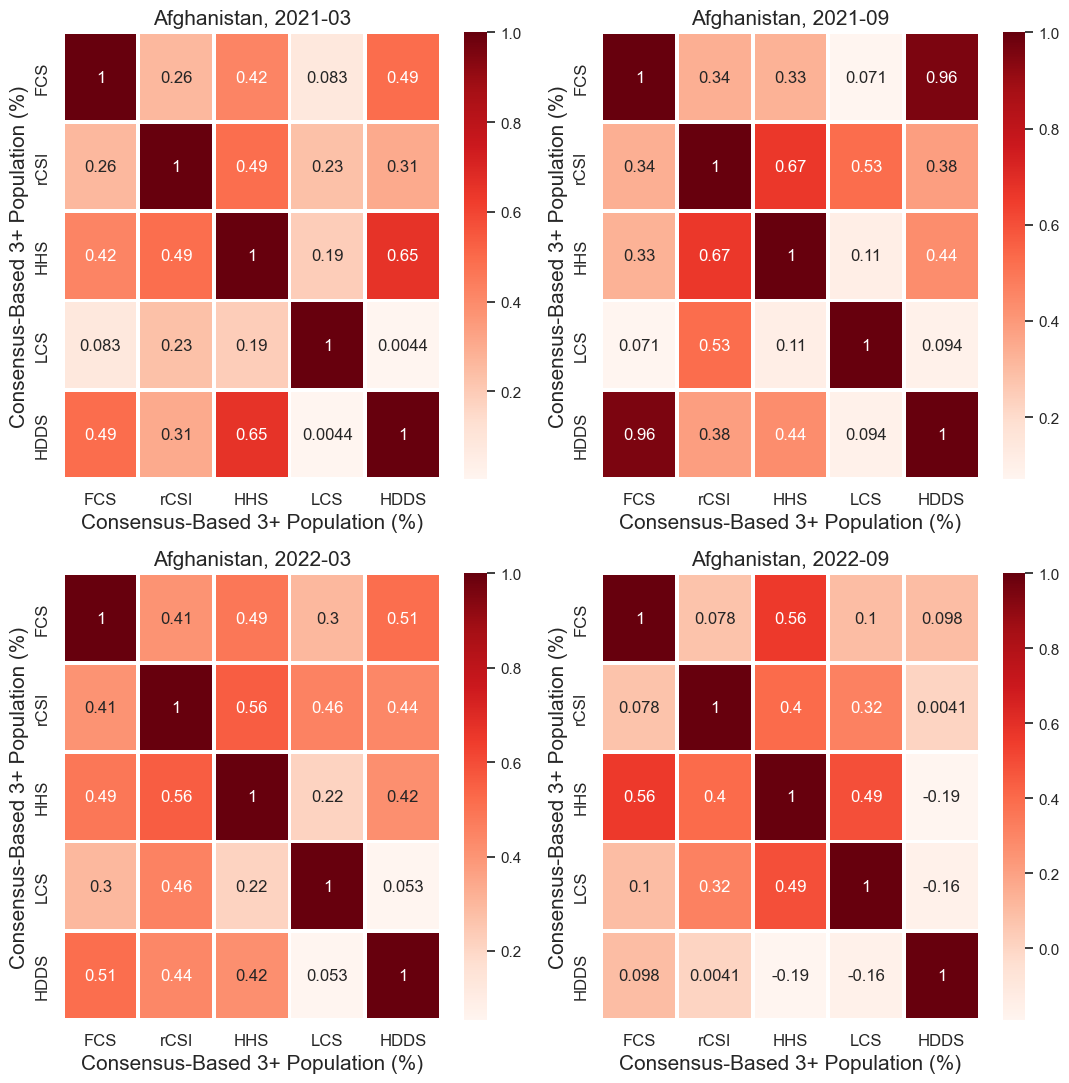

In [29]:
# TWG level
fig, ax = plt.subplots(2, 2, figsize=(11, 11))

print([t for t in df if t.endswith('_up')][1:6])
subdf = test_df[[t for t in test_df if t.endswith('_up')][1:6]+['index']]

countries = sorted([t for t in test_df['index'].unique() if 'Afghanistan' in t])

def parse_index_string(s):
    s = s.strip("()").replace("'", "")
    country, period = s.split(", ")
    return country, period

for i, country in enumerate(countries):
    row = i // 2
    col = i % 2
    sns.heatmap(subdf[subdf['index'] == country].corr(),
                annot=True, annot_kws={'size': 12},
                linewidths=2, cmap='Reds',
                yticklabels=['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS'],
                xticklabels=['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS'],
                ax=ax[row, col])
    country, period = parse_index_string(country)

    ax[row, col].set_title(f"{country}, {period}", fontsize = 15)
    ax[row, col].set_xlabel('Consensus-Based 3+ Population (%)', fontsize = 15)
    ax[row, col].set_ylabel('Consensus-Based 3+ Population (%)', fontsize = 15)

    for label in ax[row, col].get_xticklabels():
        label.set_fontsize(12)
    for label in ax[row, col].get_yticklabels():
        label.set_fontsize(12)


plt.tight_layout()


## Figure SI.3: Distribution of range in FSI implied phase classification

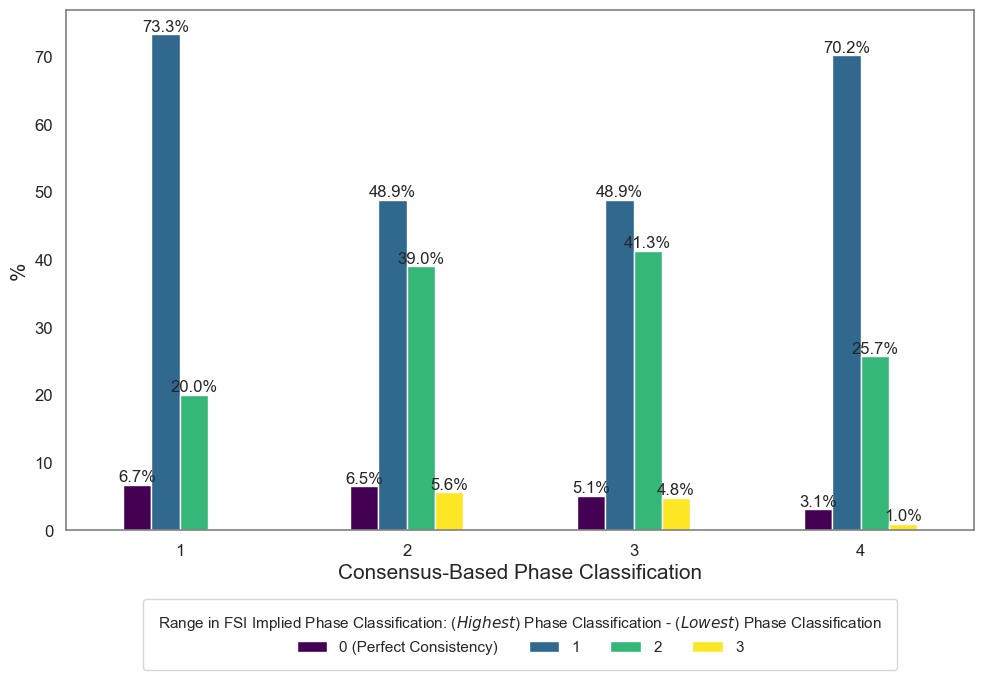

In [30]:
# create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7), facecolor='white')  # Set figure background color

# compute normalized value counts as percentages
phase_counts = ((test_df
                 .groupby('overall_phase')['class_range']
                 .value_counts(normalize=True)
                 .round(3)) * 100).unstack()

# plot the bar chart
bar_plot = phase_counts.plot(kind='bar', ax=ax, cmap='viridis')

# set custom x-axis ticks and labels
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 2, 3, 4], rotation=0)

for label in ax.get_xticklabels():
    label.set_fontsize(12)

for label in ax.get_yticklabels():
    label.set_fontsize(12)

# annotate bars with percentage values
for container in bar_plot.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Avoid labeling bars with zero height
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', 
                    ha='center', va='bottom', fontsize=12)

# set x-axis and y-axis labels
ax.set_xlabel('Consensus-Based Phase Classification', fontsize=15)
ax.set_ylabel('%', fontsize=15)

# customize frame color to gray
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

# adjust frame thickness if needed
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

# remove background grid
ax.grid(False)

# set legend outside the plot
ax.legend(["0 (Perfect Consistency)", 1, 2, 3], 
          title='Range in FSI Implied Phase Classification: ($Highest$) Phase Classification - ($Lowest$) Phase Classification',
          bbox_to_anchor=(0.5, -0.2), ncol=4, borderpad=1, loc='center', fontsize=11, title_fontsize=11)

# displa
plt.tight_layout()
plt.show()


### Table SI.3. Share of FSI implied classes consistent with consensus outcome by Phase Classification

Checking FSI implied phase outcomes consistent with Consensus-Based Phase Outcome

In [31]:
# select base columns
test_df_new = test_df.copy()

# create binary match matrix: 1 if matches overall_phase, 0 if not, NaN if missing
match_matrix = pd.DataFrame({
    col: np.where(test_df_new[col] == test_df_new['overall_phase'], 1,
                  np.where(test_df_new[col].isnull(), np.nan, 0))
    for col in class_cols
})

# assign back to test_df_new
test_df_new[class_cols] = match_matrix

# compute summary statistics
test_df_new['class_total'] = test_df_new['FSI_combination'].str.split('-').str.len()
test_df_new['class_consistent'] = match_matrix.sum(axis=1)
test_df_new['class_consistent_perc'] = (test_df_new['class_consistent'] / test_df_new['class_total']).round(30)

# compute mean percentage of consistent indicators per overall phase (excluding Haiti Sep 2022)
result = (
    test_df_new
    .groupby('overall_phase')['class_consistent_perc']
    .mean()
    .mul(100)
    .round(2)
)

result

overall_phase
1.0    27.78
2.0    46.89
3.0    51.51
4.0    43.72
Name: class_consistent_perc, dtype: float64

## Figure SI.4. Marginal effects (i.e. implicit weights) of FSI on consensus-based 3+ and 4+ population shares from fractional logistic model, by data group

FCS-RCSI-HHS-LCS-HDDS
Optimization terminated successfully.
         Current function value: 0.644149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.211593
         Iterations 6
FCS-RCSI-HHS-LCS
Optimization terminated successfully.
         Current function value: 0.580934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.131619
         Iterations 7
FCS-RCSI-LCS-HDDS
Optimization terminated successfully.
         Current function value: 0.392468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.062953
         Iterations 7
FCS-RCSI-LCS
Optimization terminated successfully.
         Current function value: 0.381863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.071024
         Iterations 7


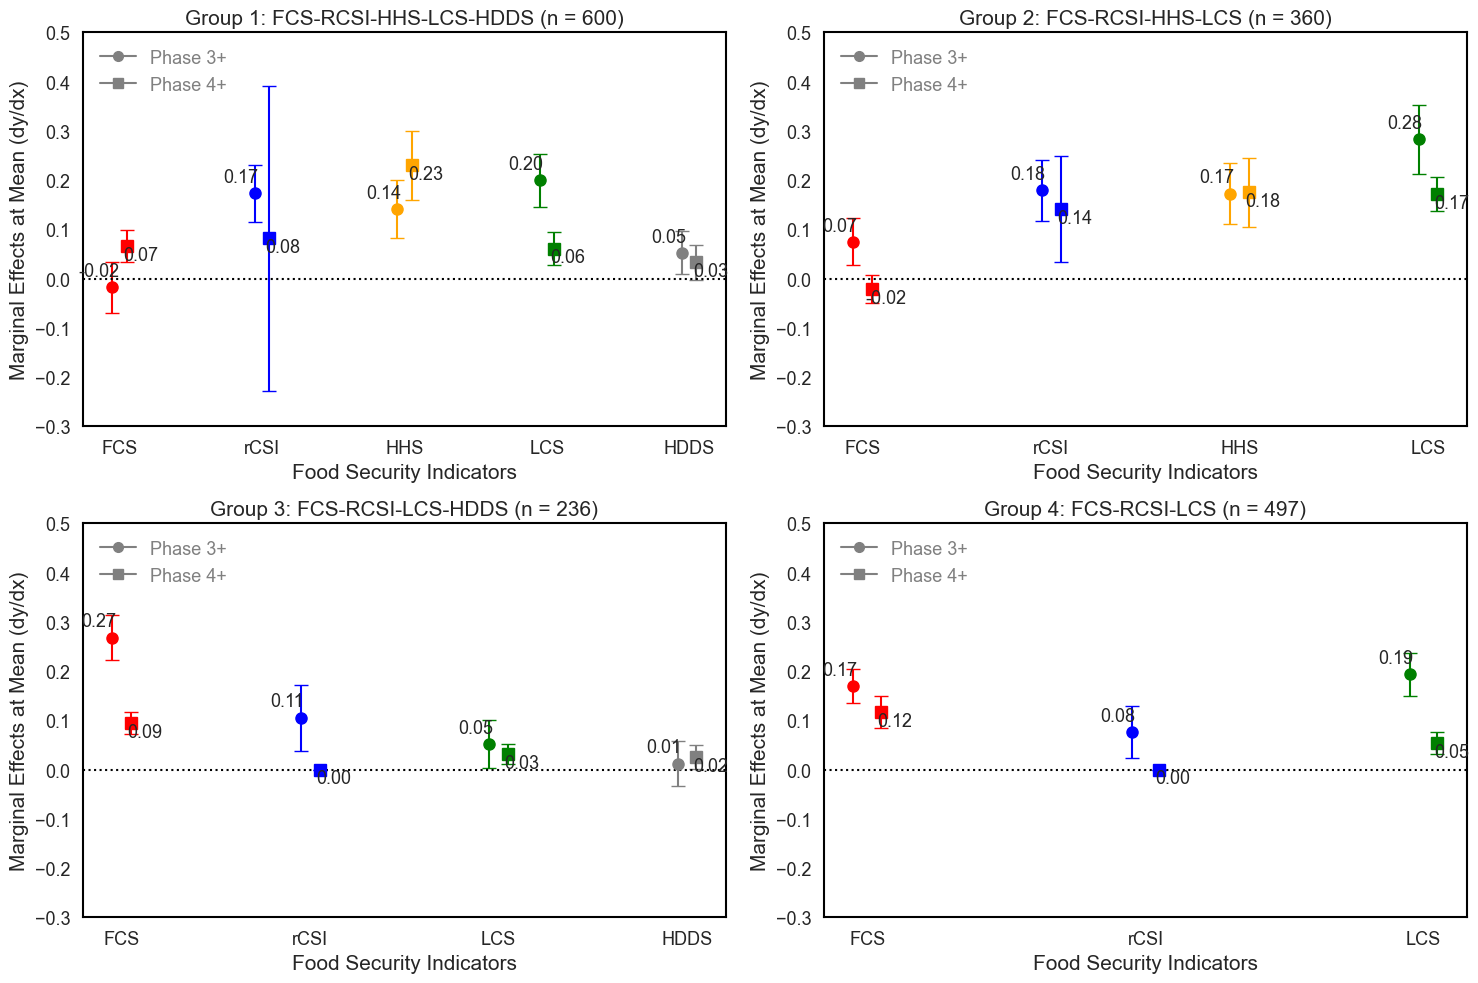

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Initialize figure for 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Variable display map for color and labels
variable_display_map = {
    'FCS_3plus_up': ('FCS', 'red'),
    'rCSI_3plus_up': ('rCSI', 'blue'),
    'hhs_3plus_up': ('HHS', 'orange'),
    'lcs_3plus_up': ('LCS', 'green'),
    'hdds_3plus_up': ('HDDS', 'gray')
}

# Loop through each FSI group
for num, fsi_combi in enumerate(test_df_sub['FSI_combination'].unique()):
    print(fsi_combi)
    
    # Get predictor sets
    variables3 = combi_match[fsi_combi]
    variables4 = combi_match4[fsi_combi]

    # ---- Phase 3+ Model ----
    reg_df3 = test_df_sub[test_df_sub['FSI_combination'] == fsi_combi].dropna(subset=variables3 + ['phase3_plus_up'])
    y3 = reg_df3['phase3_plus_up']
    X3 = sm.add_constant(reg_df3[variables3])

    model3 = sm.Logit(y3, X3).fit(cov_type='HC1')
    margeff3 = model3.get_margeff(at='mean', method='dydx')
    me_df3 = margeff3.summary_frame()
    effects3 = me_df3['dy/dx'].values
    std_errs3 = me_df3['Std. Err.'].values

    # ---- Phase 4+ Model ----
    reg_df4 = test_df_sub[test_df_sub['FSI_combination'] == fsi_combi].dropna(subset=variables4 + ['phase4_plus_up'])
    y4 = reg_df4['phase4_plus_up']
    X4 = sm.add_constant(reg_df4[variables4])

    # Drop rCSI_4plus_up only for Group 3 and 4
    drop_rCSI = (num in [2, 3]) and ('rCSI_4plus_up' in X4.columns)
    if drop_rCSI:
        X4 = X4.drop(columns='rCSI_4plus_up')

    model4 = sm.Logit(y4, X4).fit(cov_type='HC1')
    me_df4 = model4.get_margeff(at='mean', method='dydx').summary_frame()

    effects4 = me_df4['dy/dx'].values
    std_errs4 = me_df4['Std. Err.'].values

    # If rCSI_4plus_up was dropped, insert 0s at index 1 to maintain array length
    if drop_rCSI:
        effects4 = np.insert(effects4, 1, 0.0)
        std_errs4 = np.insert(std_errs4, 1, 0.0)

    # Get color and label for each variable
    colors = [variable_display_map[var][1] for var in variables3]
    labels = [variable_display_map[var][0] for var in variables3]

    # ---- Color and Label Setup ----
    color_dict = {
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['red', 'blue', 'orange', 'green', 'gray'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'): ['red', 'blue', 'orange', 'green'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['red', 'blue', 'green', 'gray'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'): ['red', 'blue', 'green']
    }

    gca_dict = {
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'): ['FCS', 'rCSI', 'HHS', 'LCS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['FCS', 'rCSI', 'LCS', 'HDDS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'): ['FCS', 'rCSI', 'LCS']
    }

    colors = color_dict.get(tuple(variables3), ['red', 'blue', 'orange', 'green', 'gray'])
    labels = gca_dict.get(tuple(variables3), variables3)

    # ---- Plotting ----
    ax = axs[num]
    width = 0.1

    for i, color in enumerate(colors):
        # Phase 3+ (Circles)
        ax.errorbar(i - width / 2, effects3[i], yerr=1.96 * std_errs3[i],
                    color=color, fmt='o', markersize=8, capsize=5, label="Phase 3+" if i == 0 else "")
        ax.annotate(f'{effects3[i]:.2f}', (i - width / 2, effects3[i]),
                    xytext=(-10, 8), textcoords="offset points", ha='center', fontsize=13)
        
        # Phase 4+ (Squares)
        ax.errorbar(i + width / 2, effects4[i], yerr=1.96 * std_errs4[i],
                    color=color, fmt='s', markersize=8, capsize=5, label="Phase 4+" if i == 0 else "")
        ax.annotate(f'{effects4[i]:.2f}', (i + width / 2, effects4[i]),
                    xytext=(10, -10), textcoords="offset points", ha='center', fontsize=13)
        
    ax.set_xticks(range(len(variables3)))
    ax.set_xticklabels(labels, fontsize=14)
    ax.axhline(y=0, color='black', linestyle=':')
    ax.set_ylabel('Marginal Effects at Mean (dy/dx)', fontsize=15)
    ax.set_xlabel('Food Security Indicators', fontsize=15)
    ax.set_title(f'Group {num+1}: {fsi_combi} (n = {len(reg_df3)})', fontsize=15)
    ax.set_ylim([-0.3, 0.5])
    ax.grid(False)

    # Styling
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(13)

    # Custom legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='gray', linestyle='-', markersize=7, label="Phase 3+"),
        plt.Line2D([0], [0], marker='s', color='gray', linestyle='-', markersize=7, label="Phase 4+")
    ]
    legend = ax.legend(handles=legend_elements, fontsize=13, loc="upper left", frameon=False)
    for text in legend.get_texts():
        text.set_color("gray")

# Finalize layout
plt.tight_layout()
plt.show()


## Figure SI.5. : Country-specific marginal effects (i.e. implicit weights) of FSIs on consensus-based 3+ population shares from fractional logistic model, by data group (This set of figure is run in STATA)

In [33]:
import stata_setup
stata_setup.config("C:/Program Files/Stata18", "mp")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      18.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: 14-student 2-core lab perpetual
Serial number: 501806322531
  Licensed to: Dept of ACE
               University of Illinois Urbana-Champaign

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.



. import delimited "C:\Users\ck24\OneDrive - University of Illinois - Urbana\Do
> cuments\ipc_consistency_paper\stores\test_df_colab", clear
(encoding automatically selected: ISO-8859-1)
(138 vars, 1,849 obs)

. drop country

. encode country_name, gen(country)

. 
. fracreg logit phase3_plus_up ///
>     c.fcs_3plus_up##i.country ///
>     c.rcsi_3plus_up##i.country ///
>     c.hhs_3plus_up##i.country ///
>     c.lcs_3plus_up##i.country ///
>     c.hdds_3plus_up##i.country ///
>     if fsi_combination == "FCS-RCSI-HHS-LCS-HDDS"

Iteration 0:  Log pseudolikelihood = -440.35525  
Iteration 1:  Log pseudolikelihood = -392.40184  
Iteration 2:  Log pseudolikelihood = -392.29668  
Iteration 3:  Log pseudolikelihood = -392.29661  
Iteration 4:  Log pseudolikelihood = -392.29661  

Fractional logistic regression                         Number of obs =     600
                                                       Wald chi2(35) = 1604.05
                                                      


. 
. marginsplot, ///
>     recast(scatter) ///
>     by(country) ///
>     xtitle("Food Security Indicators") ///
>     ytitle("Marginal Effect at Means (dy/dx)") ///
>     xlabel(1 "FCS" 2 "rCSI" 3 "HHS" 4 "LCS" 5 "HDDS", angle(45)) ///
>     plot1opts(mcolor(red)) ///
>     yline(0, lpattern(dash) lcolor(black)) ///
>     byopt(title("Group 1: FCS-RCSI-HHS-LCS-HDDS (n = 600)"))

Variables that uniquely identify margins: country _deriv

. 
. graph export "C:\Users\ck24\Downloads\marginsplot_output_gr1.png", width(2000
> ) replace
file C:\Users\ck24\Downloads\marginsplot_output_gr1.png written in PNG format

. 


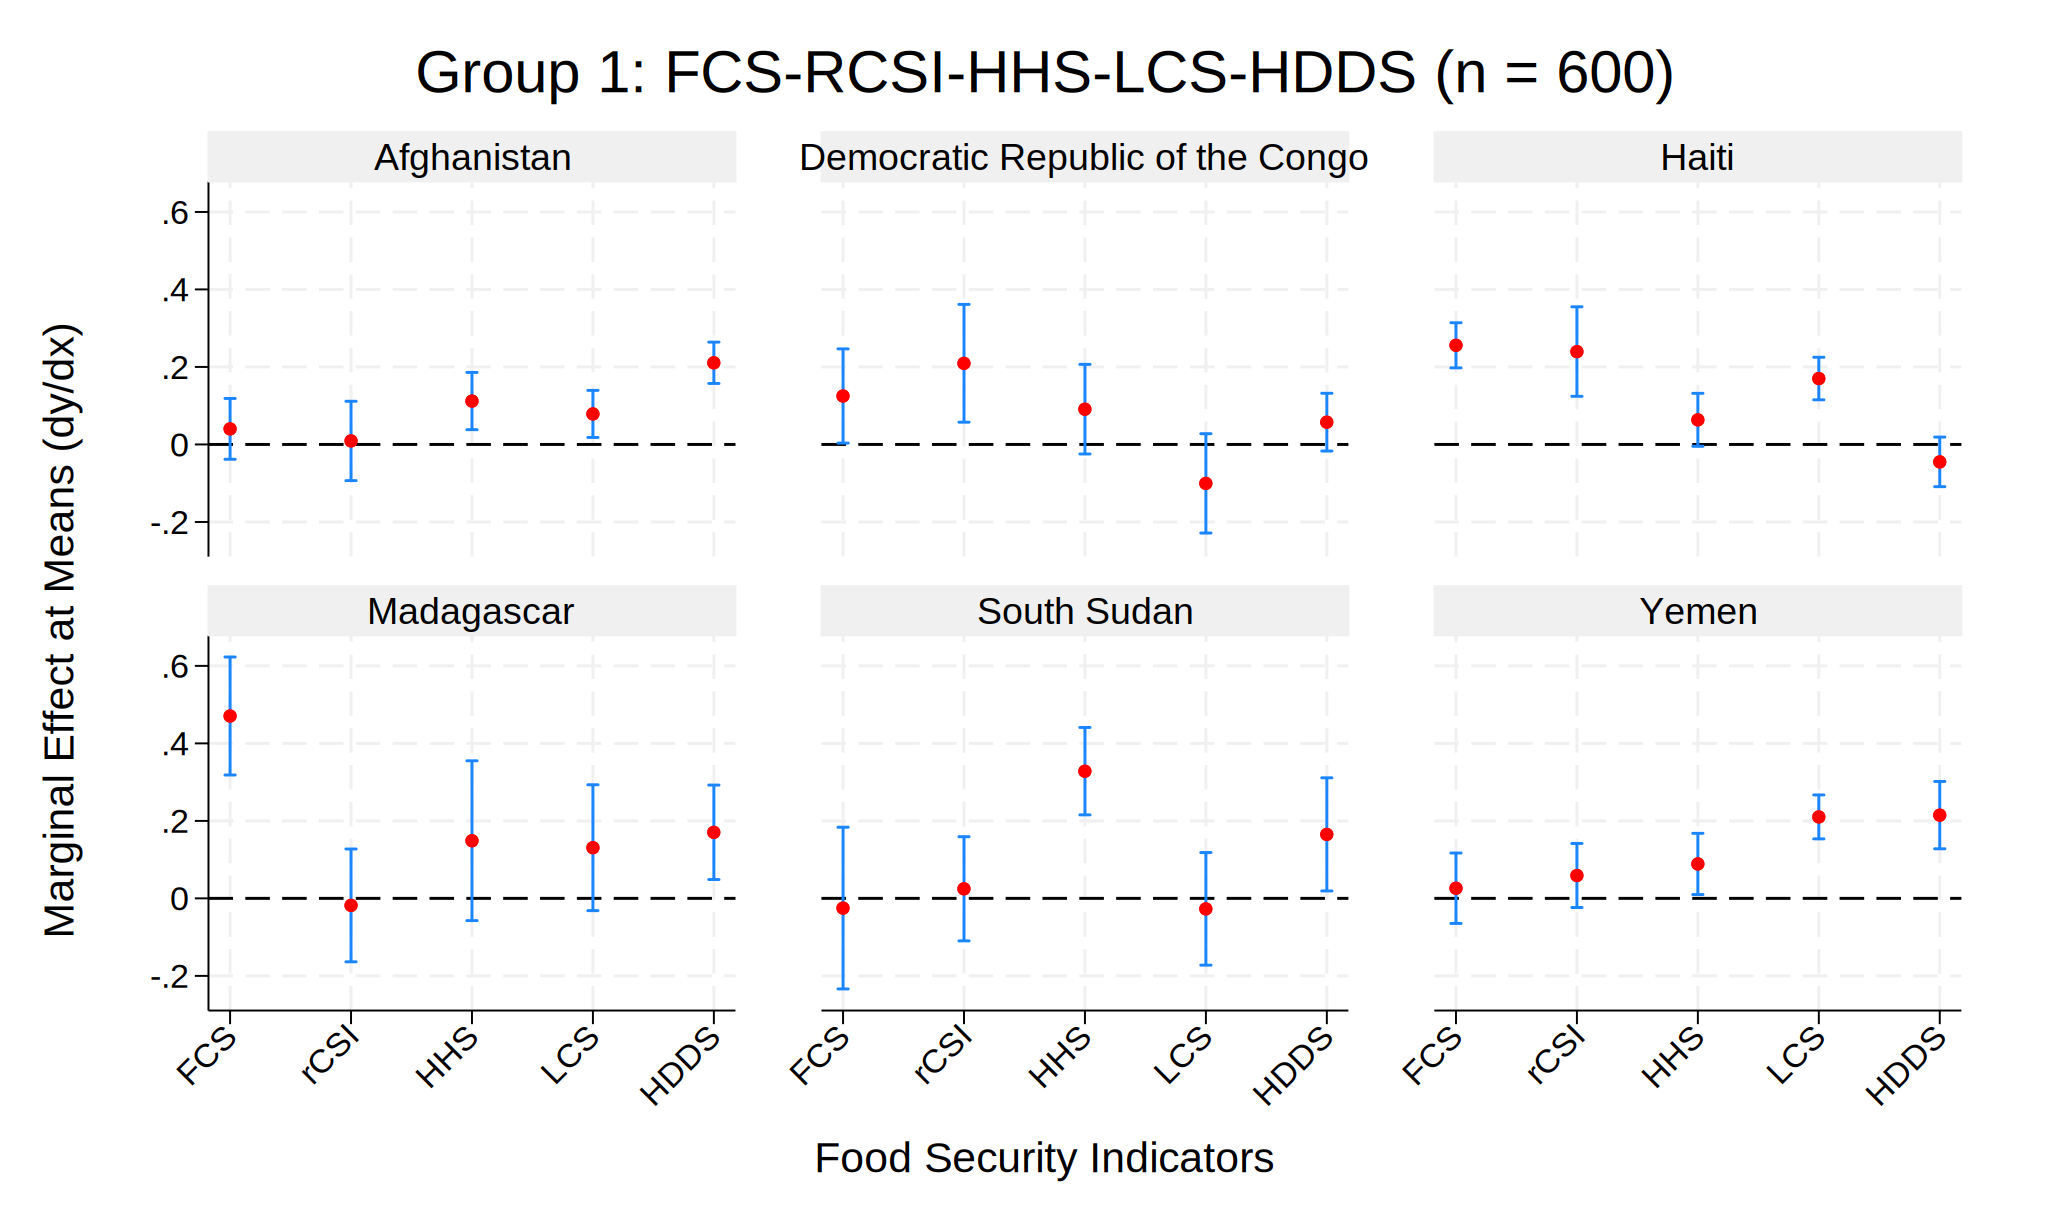

In [34]:
%%stata
import delimited "C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\ipc_consistency_paper\stores\test_df_colab", clear
drop country
encode country_name, gen(country)

fracreg logit phase3_plus_up ///
    c.fcs_3plus_up##i.country ///
    c.rcsi_3plus_up##i.country ///
    c.hhs_3plus_up##i.country ///
    c.lcs_3plus_up##i.country ///
    c.hdds_3plus_up##i.country ///
    if fsi_combination == "FCS-RCSI-HHS-LCS-HDDS"

margins country, dydx(fcs_3plus_up rcsi_3plus_up hhs_3plus_up lcs_3plus_up hdds_3plus_up)

marginsplot, ///
    recast(scatter) ///
    by(country) ///
    xtitle("Food Security Indicators") ///
    ytitle("Marginal Effect at Means (dy/dx)") ///
    xlabel(1 "FCS" 2 "rCSI" 3 "HHS" 4 "LCS" 5 "HDDS", angle(45)) ///
    plot1opts(mcolor(red)) ///
    yline(0, lpattern(dash) lcolor(black)) ///
    byopt(title("Group 1: FCS-RCSI-HHS-LCS-HDDS (n = 600)"))

graph export "C:\Users\ck24\Downloads\marginsplot_output_gr1.png", width(2000) replace



. import delimited "C:\Users\ck24\OneDrive - University of Illinois - Urbana\Do
> cuments\ipc_consistency_paper\stores\test_df_colab", clear
(encoding automatically selected: ISO-8859-1)
(138 vars, 1,849 obs)

. 
. drop country

. encode country_name, gen(country)

. 
. fracreg logit phase3_plus_up ///
>     c.fcs_3plus_up##i.country ///
>     c.rcsi_3plus_up##i.country ///
>     c.hhs_3plus_up##i.country ///
>     c.lcs_3plus_up##i.country ///
>     if fsi_combination == "FCS-RCSI-HHS-LCS"

Iteration 0:  Log pseudolikelihood = -260.11688  
Iteration 1:  Log pseudolikelihood = -217.35724  
Iteration 2:  Log pseudolikelihood = -217.10774  
Iteration 3:  Log pseudolikelihood = -217.10704  
Iteration 4:  Log pseudolikelihood = -217.10704  

Fractional logistic regression                          Number of obs =    347
                                                        Wald chi2(9)  = 666.58
                                                        Prob > chi2   = 0.0000
Log pseudolike

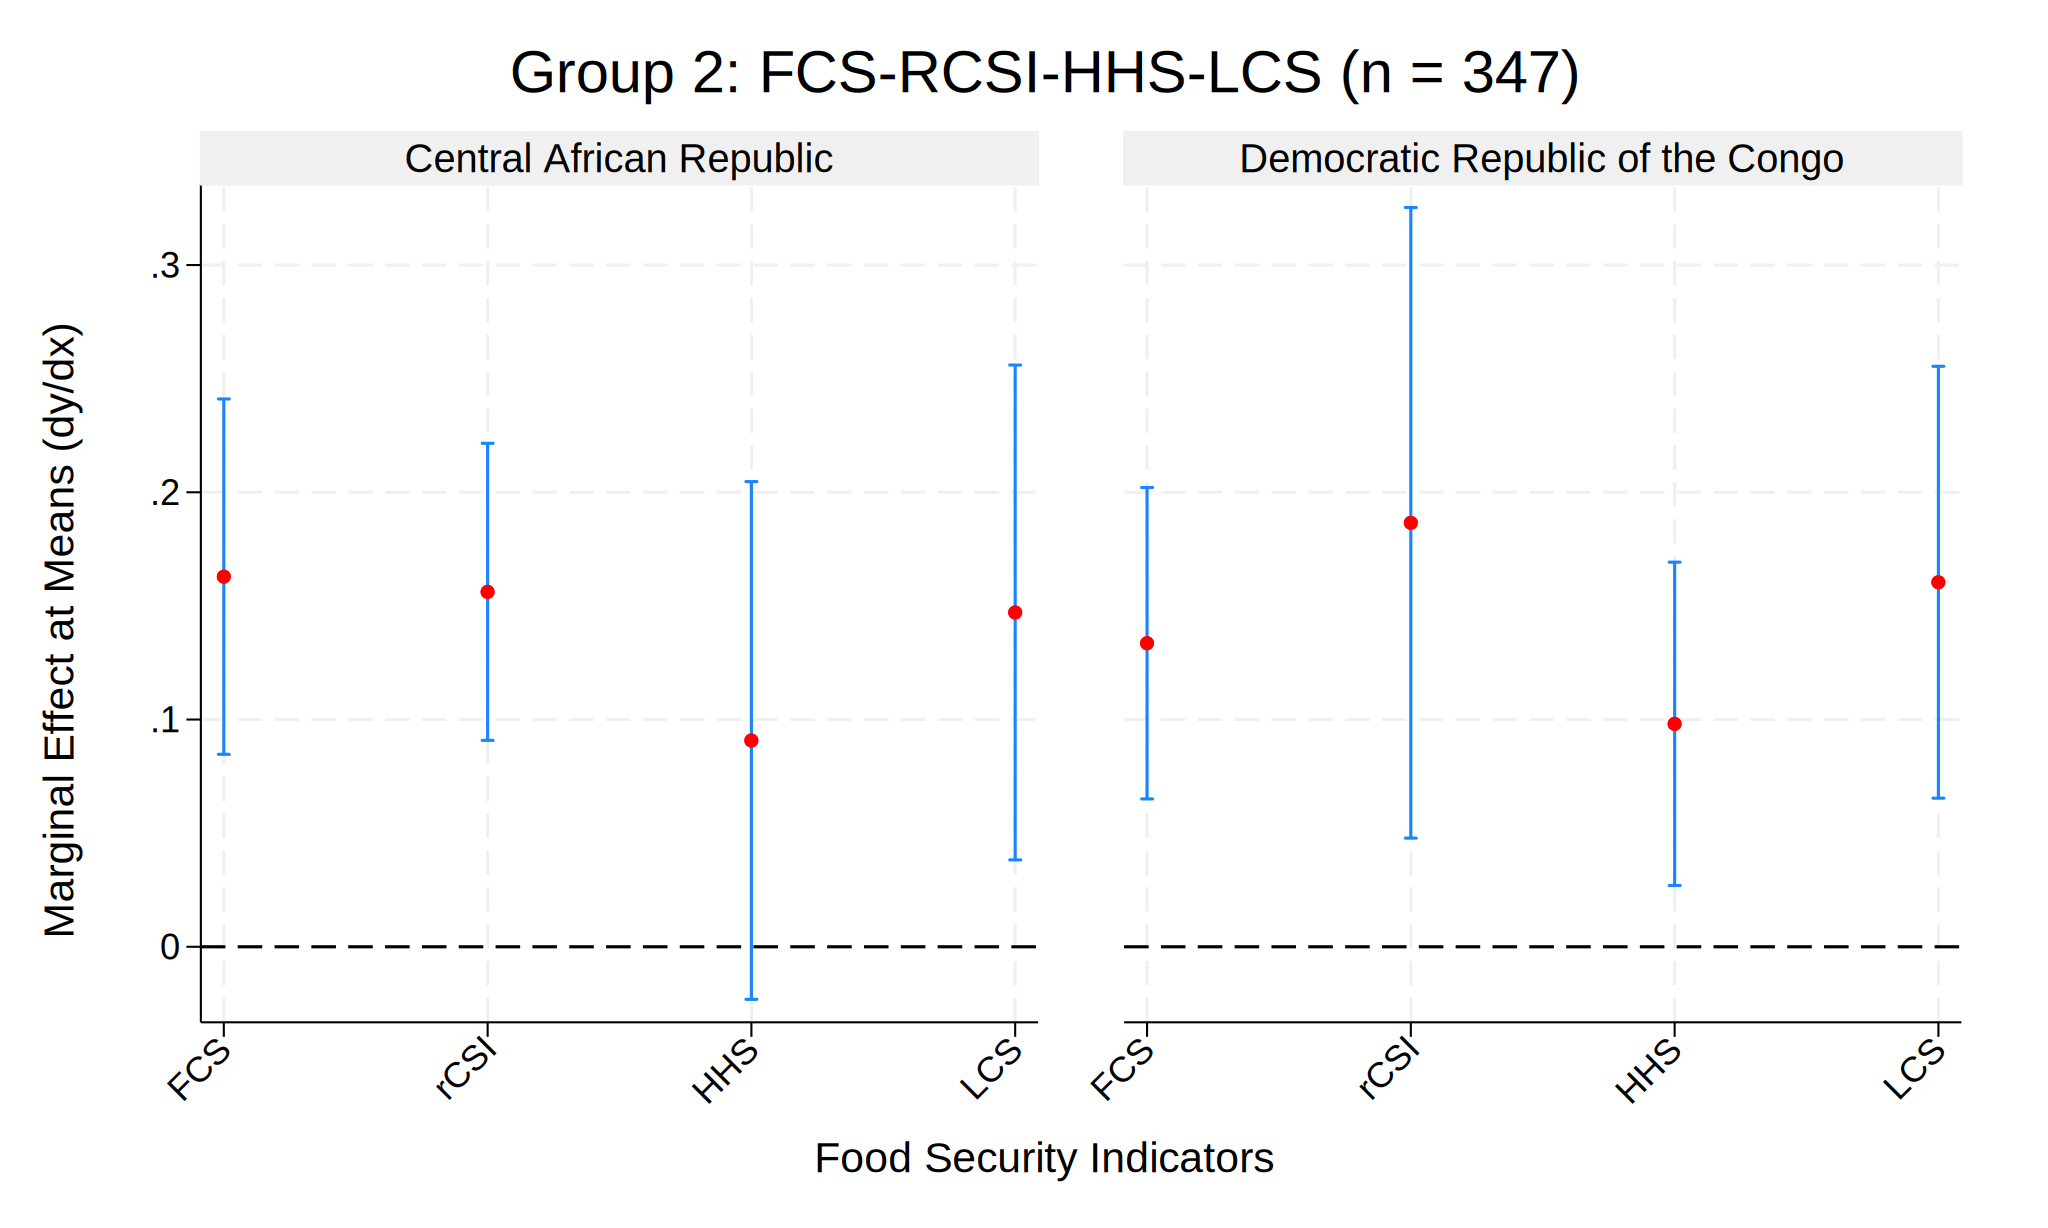

In [35]:
%%stata
import delimited "C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\ipc_consistency_paper\stores\test_df_colab", clear

drop country
encode country_name, gen(country)

fracreg logit phase3_plus_up ///
    c.fcs_3plus_up##i.country ///
    c.rcsi_3plus_up##i.country ///
    c.hhs_3plus_up##i.country ///
    c.lcs_3plus_up##i.country ///
    if fsi_combination == "FCS-RCSI-HHS-LCS"

margins country, dydx(fcs_3plus_up rcsi_3plus_up hhs_3plus_up lcs_3plus_up)

marginsplot, ///
    recast(scatter) ///
    by(country) ///
    xtitle("Food Security Indicators") ///
    ytitle("Marginal Effect at Means (dy/dx)") ///
    xlabel(1 "FCS" 2 "rCSI" 3 "HHS" 4 "LCS", angle(45)) ///
    plot1opts(mcolor(red)) ///
    yline(0, lpattern(dash) lcolor(black)) ///
    byopt(title("Group 2: FCS-RCSI-HHS-LCS (n = 347)"))

graph export "C:\Users\ck24\Downloads\marginsplot_output_gr2.png", width(2000) replace



. import delimited "C:\Users\ck24\OneDrive - University of Illinois - Urbana\Do
> cuments\ipc_consistency_paper\stores\test_df_colab", clear
(encoding automatically selected: ISO-8859-1)
(138 vars, 1,849 obs)

. drop country

. encode country_name, gen(country)

. 
. fracreg logit phase3_plus_up ///
>     c.fcs_3plus_up##i.country ///
>     c.rcsi_3plus_up##i.country ///
>     c.lcs_3plus_up##i.country ///
>     c.hdds_3plus_up##i.country ///
>     if fsi_combination == "FCS-RCSI-LCS-HDDS"

Iteration 0:  Log pseudolikelihood =  -166.1563  
Iteration 1:  Log pseudolikelihood = -111.93875  
Iteration 2:  Log pseudolikelihood = -111.46381  
Iteration 3:  Log pseudolikelihood = -111.45966  
Iteration 4:  Log pseudolikelihood = -111.45966  

Fractional logistic regression                          Number of obs =    221
                                                        Wald chi2(14) = 608.18
                                                        Prob > chi2   = 0.0000
Log pseudolikel

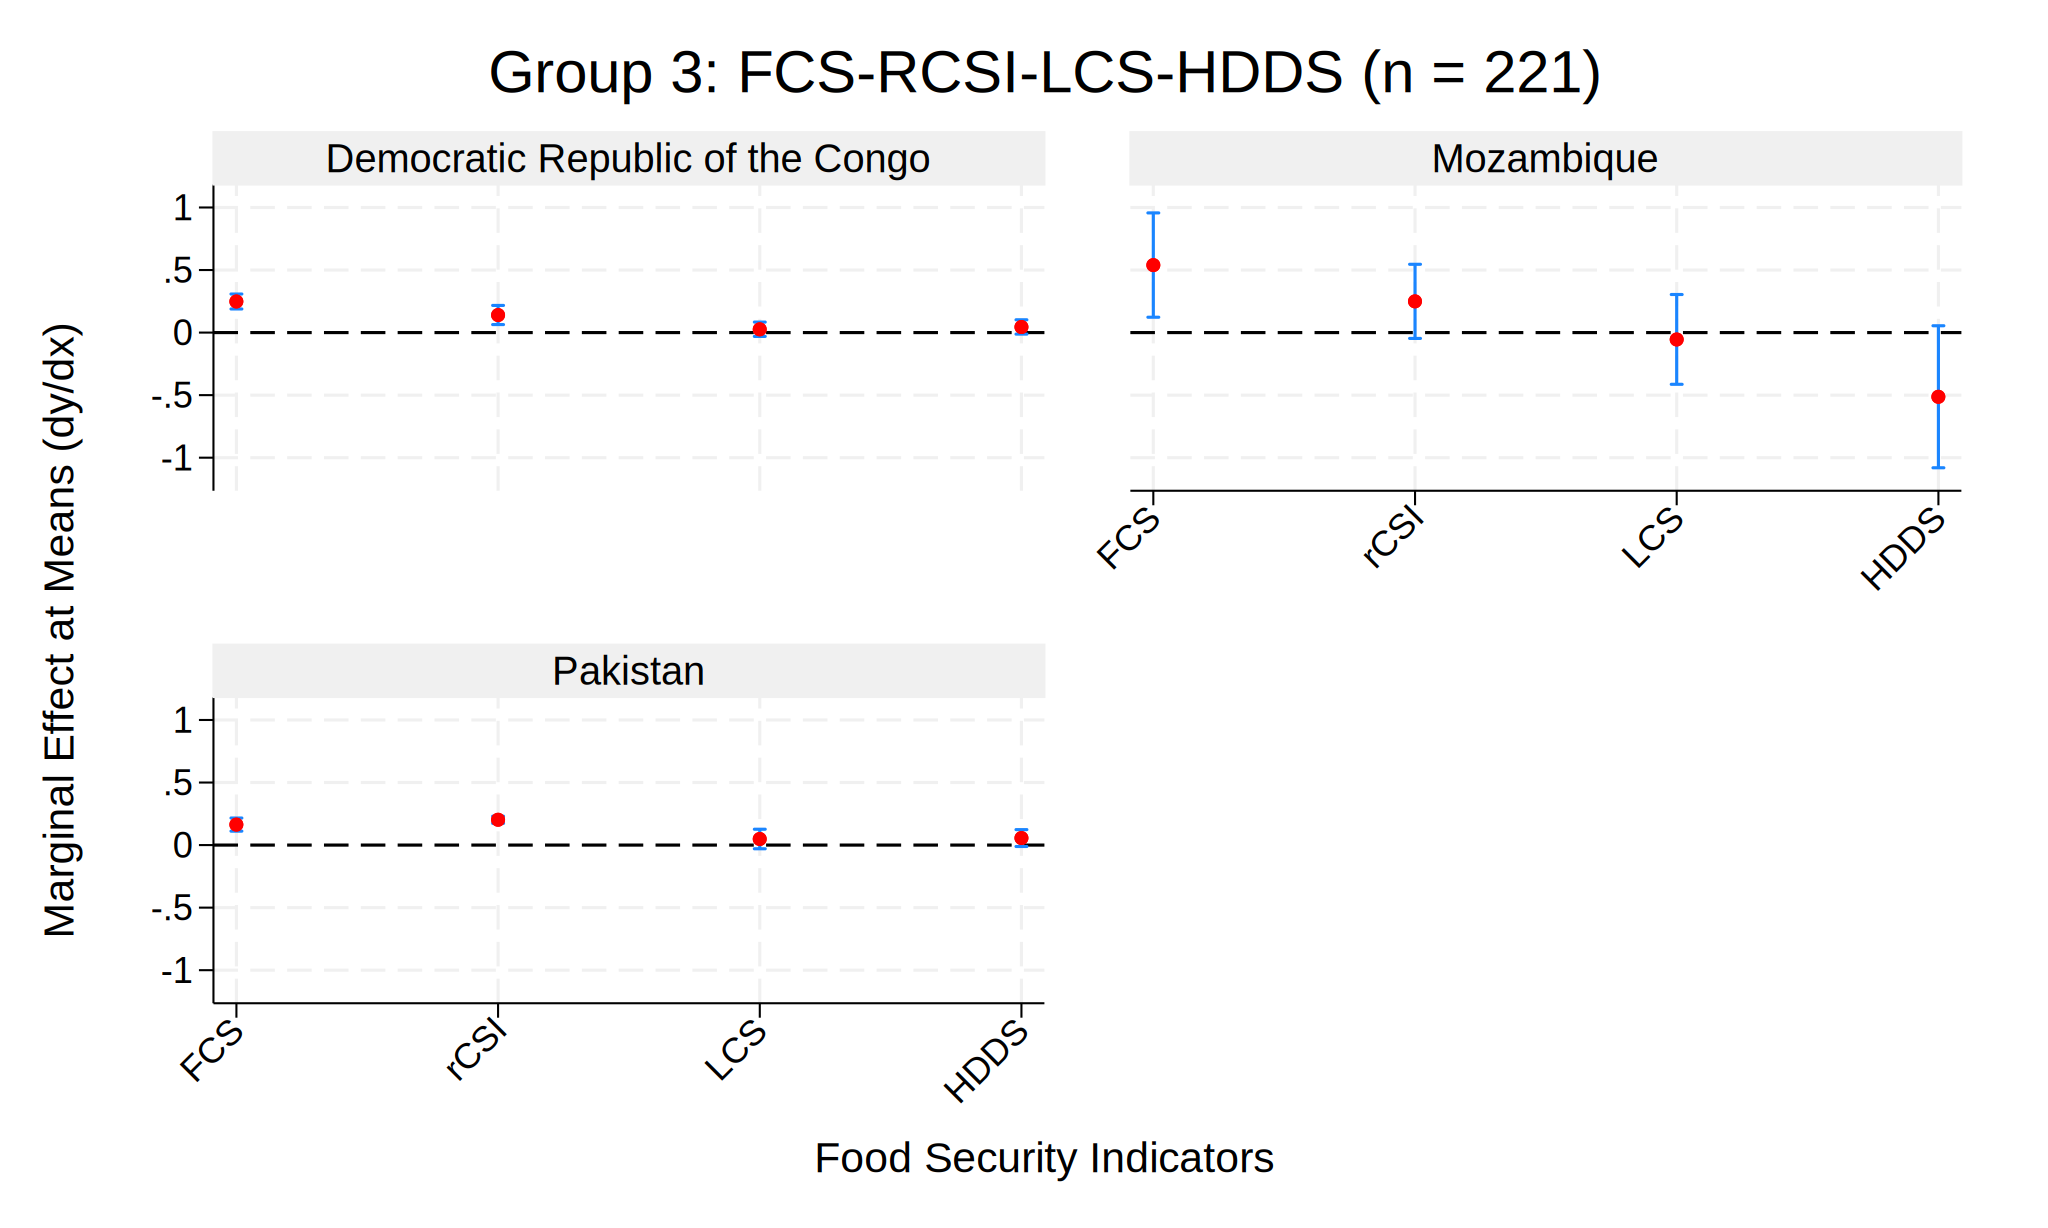

In [36]:
%%stata
import delimited "C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\ipc_consistency_paper\stores\test_df_colab", clear
drop country
encode country_name, gen(country)

fracreg logit phase3_plus_up ///
    c.fcs_3plus_up##i.country ///
    c.rcsi_3plus_up##i.country ///
    c.lcs_3plus_up##i.country ///
    c.hdds_3plus_up##i.country ///
    if fsi_combination == "FCS-RCSI-LCS-HDDS"

margins country, dydx(fcs_3plus_up rcsi_3plus_up lcs_3plus_up hdds_3plus_up)

marginsplot, ///
    recast(scatter) ///
    by(country) ///
    xtitle("Food Security Indicators") ///
    ytitle("Marginal Effect at Means (dy/dx)") ///
    xlabel(1 "FCS" 2 "rCSI" 3 "LCS" 4 "HDDS", angle(45)) ///
    plot1opts(mcolor(red)) ///
    yline(0, lpattern(dash) lcolor(black)) ///
    byopt(title("Group 3: FCS-RCSI-LCS-HDDS (n = 221)"))

graph export "C:\Users\ck24\Downloads\marginsplot_output_gr3.png", width(2000) replace



. import delimited "C:\Users\ck24\OneDrive - University of Illinois - Urbana\Do
> cuments\ipc_consistency_paper\stores\test_df_colab", clear
(encoding automatically selected: ISO-8859-1)
(138 vars, 1,849 obs)

. drop country

. encode country_name, gen(country)

. 
. fracreg logit phase3_plus_up ///
>     c.fcs_3plus_up##i.country ///
>     c.rcsi_3plus_up##i.country ///
>     c.lcs_3plus_up##i.country ///
>     if fsi_combination == "FCS-RCSI-LCS"

Iteration 0:  Log pseudolikelihood = -358.12173  
Iteration 1:  Log pseudolikelihood = -238.11728  
Iteration 2:  Log pseudolikelihood = -237.46492  
Iteration 3:  Log pseudolikelihood = -237.45757  
Iteration 4:  Log pseudolikelihood = -237.45757  

Fractional logistic regression                          Number of obs =    475
                                                        Wald chi2(15) = 663.11
                                                        Prob > chi2   = 0.0000
Log pseudolikelihood = -237.45757                       P

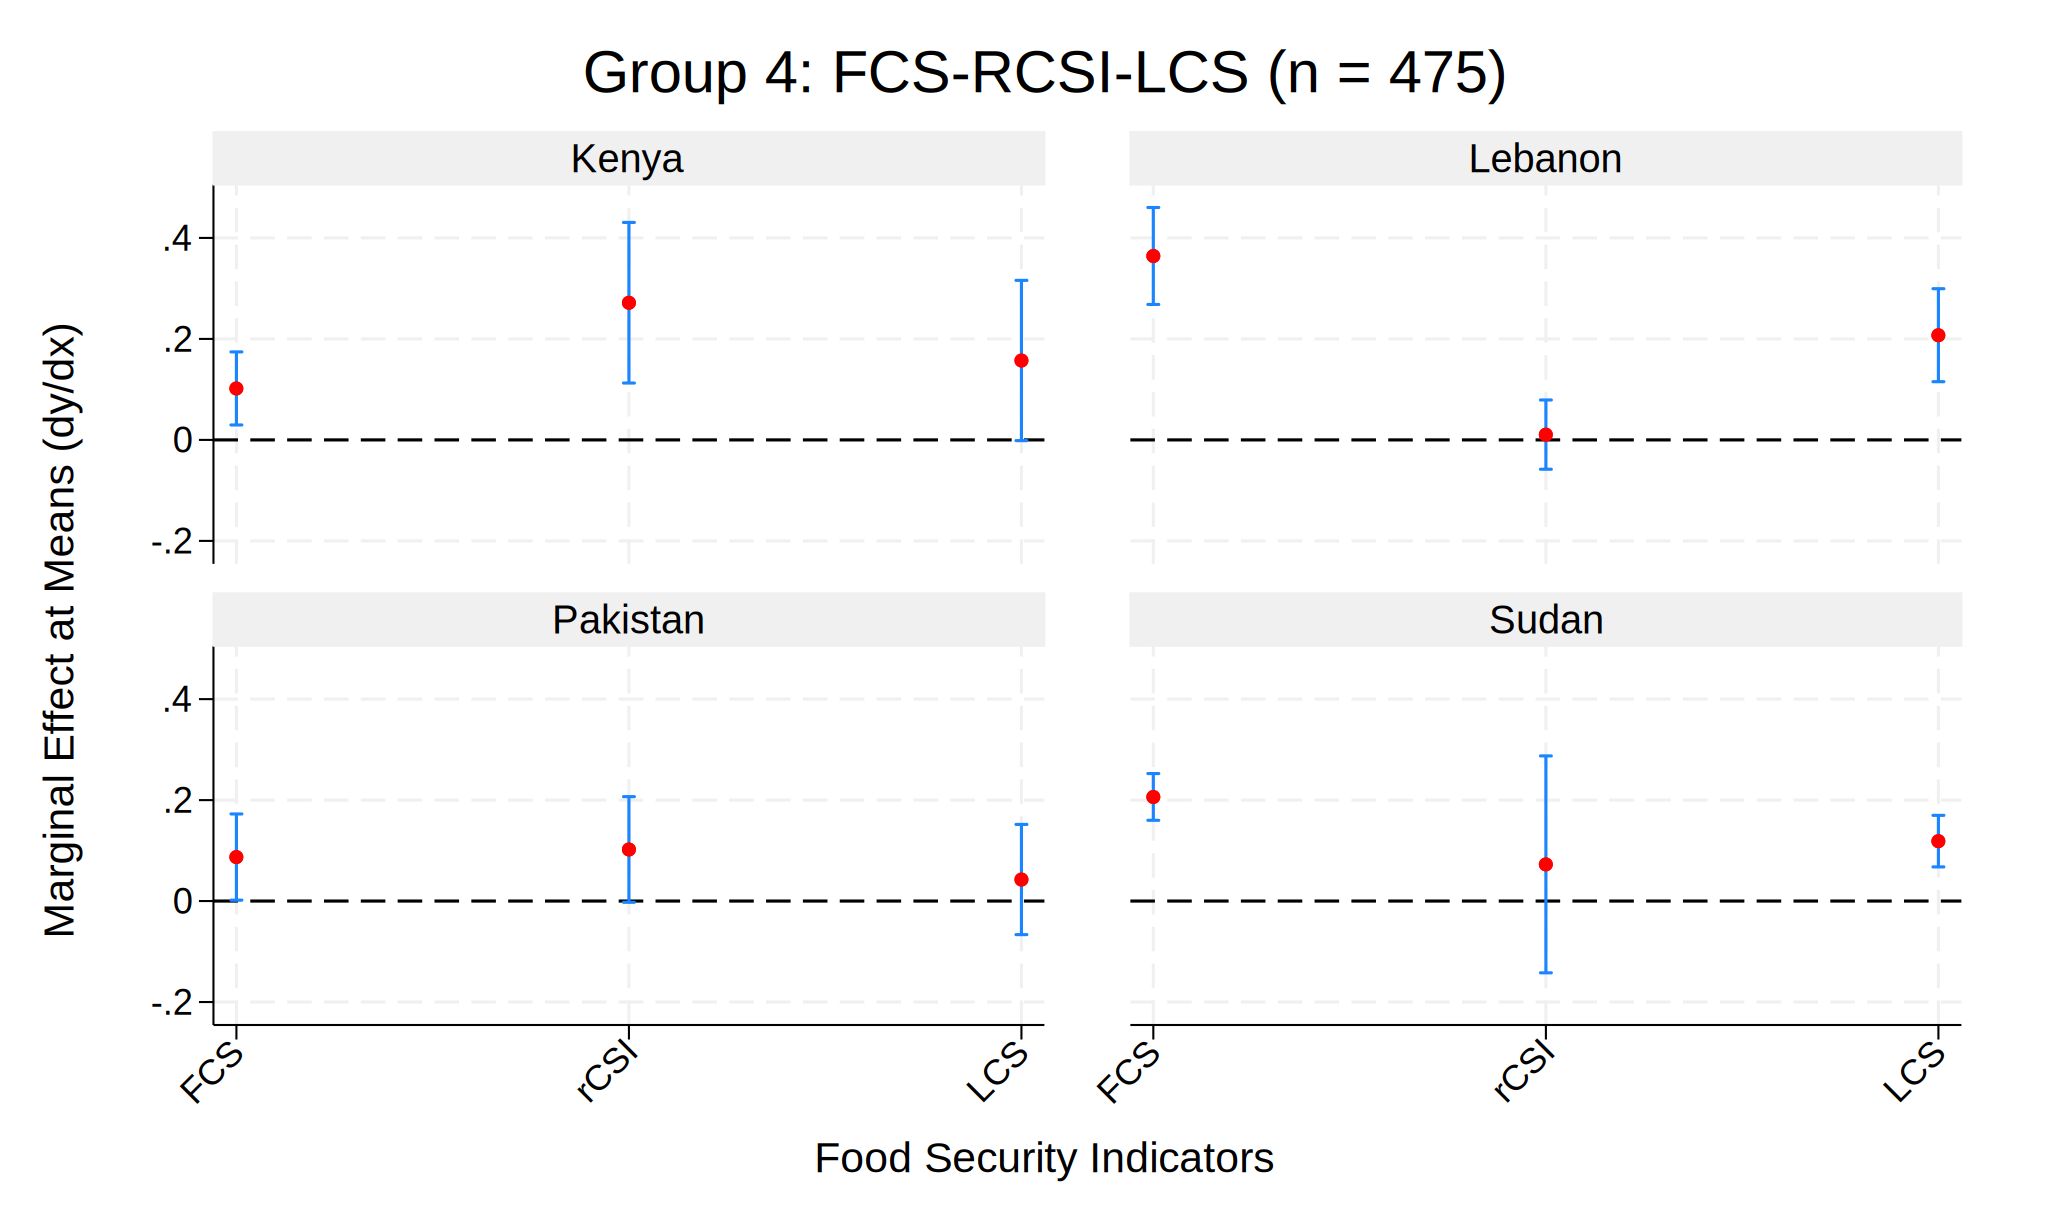

In [37]:
%%stata
import delimited "C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\ipc_consistency_paper\stores\test_df_colab", clear
drop country
encode country_name, gen(country)

fracreg logit phase3_plus_up ///
    c.fcs_3plus_up##i.country ///
    c.rcsi_3plus_up##i.country ///
    c.lcs_3plus_up##i.country ///
    if fsi_combination == "FCS-RCSI-LCS"

margins country, dydx(fcs_3plus_up rcsi_3plus_up lcs_3plus_up)

marginsplot, ///
    recast(scatter) ///
    by(country) ///
    xtitle("Food Security Indicators") ///
    ytitle("Marginal Effect at Means (dy/dx)") ///
    xlabel(1 "FCS" 2 "rCSI" 3 "LCS", angle(45)) ///
    plot1opts(mcolor(red)) ///
    yline(0, lpattern(dash) lcolor(black)) ///
    byopt(title("Group 4: FCS-RCSI-LCS (n = 475)"))

graph export "C:\Users\ck24\Downloads\marginsplot_output_gr4.png", width(2000) replace


## Figure SI.6: Marginal effects (i.e. implicit weights) of FSIs on consensus-based 3+ population shares from fractional logistic model, by round: Central African Republic and Madagascar

Optimization terminated successfully.
         Current function value: 0.646083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673636
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.542881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567479
         Iterations 5


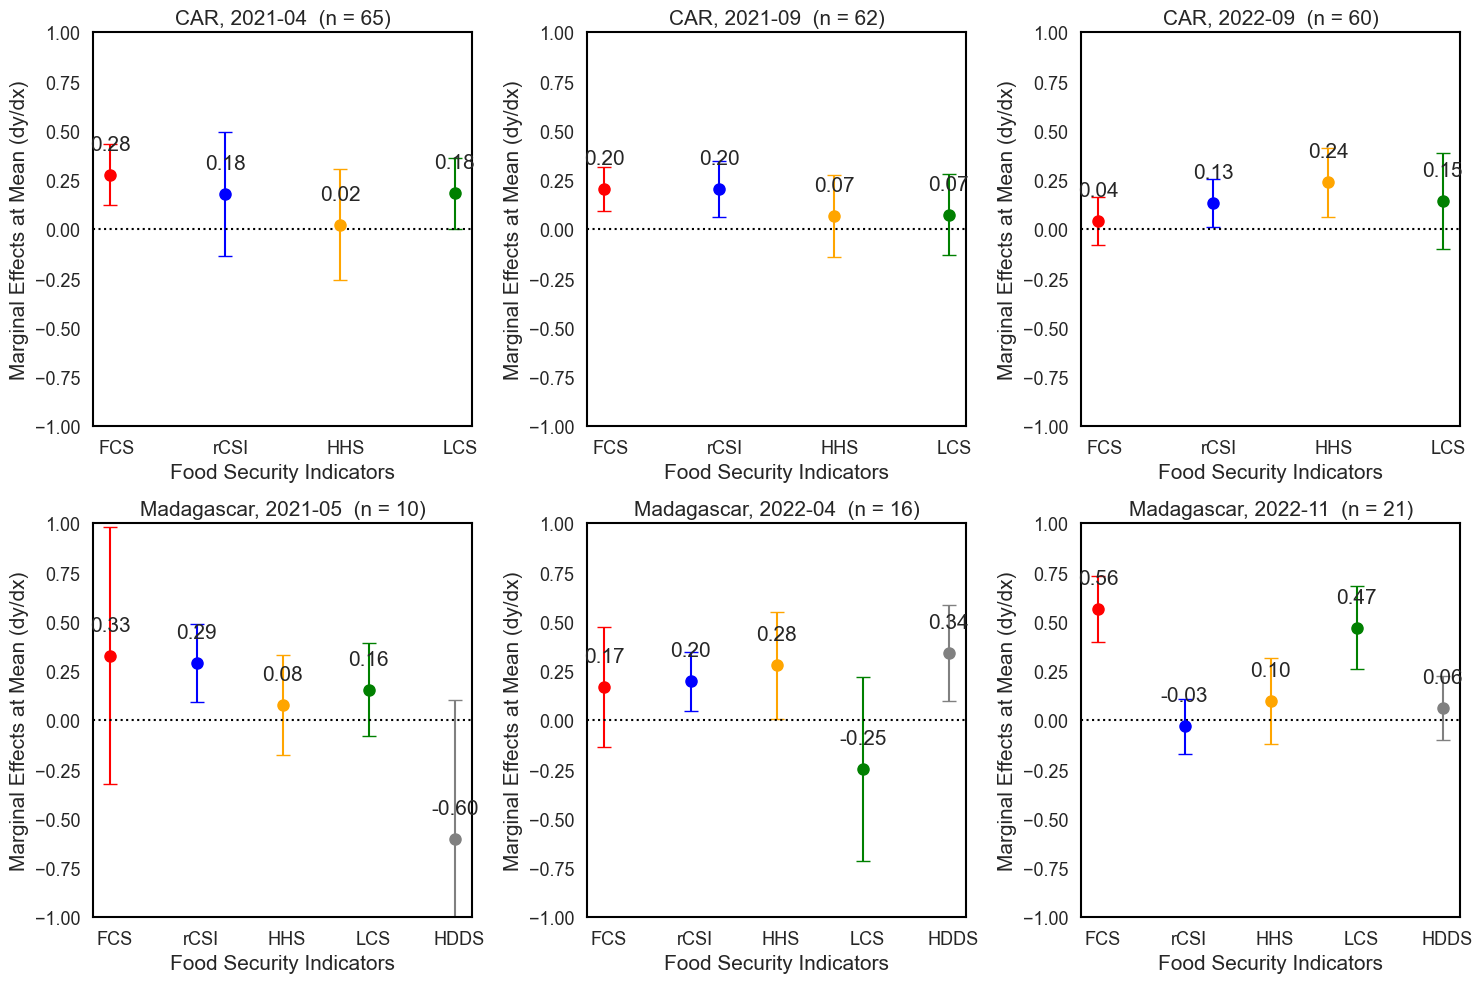

In [38]:
# Initialize figure for 2x2 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# Variable display map for color and labels
variable_display_map = {
    'FCS_3plus_up': ('FCS', 'red'),
    'rCSI_3plus_up': ('rCSI', 'blue'),
    'hhs_3plus_up': ('HHS', 'orange'),
    'lcs_3plus_up': ('LCS', 'green'),
    'hdds_3plus_up': ('HDDS', 'gray')
}

# Loop through each FSI group
for num, fsi_combi in enumerate(sorted(test_df_sub[test_df_sub['country_name'].isin(['Central African Republic','Madagascar'])]['index'].unique())):
    
    # Phase 3+ Model
    reg_df3 = test_df_sub[test_df_sub['index'] == fsi_combi]
    variables3 = combi_match[reg_df3['FSI_combination'].unique()[0]]
    reg_df3 = test_df_sub[test_df_sub['index'] == fsi_combi].dropna(subset=variables3 + ['phase3_plus_up'])
   
    
    y3 = reg_df3['phase3_plus_up']
    X3 = sm.add_constant(reg_df3[variables3])

    model3 = sm.Logit(y3, X3).fit(cov_type='HC1')
    margeff3 = model3.get_margeff(at='mean', method='dydx')
    me_df3 = margeff3.summary_frame()
    effects3 = me_df3['dy/dx'].values
    std_errs3 = me_df3['Std. Err.'].values

    # Get color and label for each variable
    colors = [variable_display_map[var][1] for var in variables3]
    labels = [variable_display_map[var][0] for var in variables3]

    # Color and Label Setup
    color_dict = {
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['red', 'blue', 'orange', 'green', 'gray'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'): ['red', 'blue', 'orange', 'green'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['red', 'blue', 'green', 'gray'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'): ['red', 'blue', 'green']
    }

    gca_dict = {
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'): ['FCS', 'rCSI', 'HHS', 'LCS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['FCS', 'rCSI', 'LCS', 'HDDS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'): ['FCS', 'rCSI', 'LCS']
    }

    colors = color_dict.get(tuple(variables3), ['red', 'blue', 'orange', 'green', 'gray'])
    labels = gca_dict.get(tuple(variables3), variables3)

    # Plotting
    ax = axs[num]
    width = 0.1

    for i, color in enumerate(colors):
        # Phase 3+ (Circles)
        ax.errorbar(i - width / 2, effects3[i], yerr=1.96 * std_errs3[i],
                    color=color, fmt='o', markersize=8, capsize=5, label="Phase 3+" if i == 0 else "")
        ax.annotate(f'{effects3[i]:.2f}', (i - width / 2, effects3[i]),
                    xytext=(0, 18), textcoords="offset points", ha='center', fontsize=15)
        
        
    ax.set_xticks(range(len(variables3)))
    ax.set_xticklabels(labels, fontsize=14)
    ax.axhline(y=0, color='black', linestyle=':')
    ax.set_ylabel('Marginal Effects at Mean (dy/dx)', fontsize=15)
    ax.set_xlabel('Food Security Indicators', fontsize=15)
    
    country_name, period_name = parse_index_string(fsi_combi)
    ax.set_title(
        f'{country_name}, {period_name}  (n = {len(reg_df3)})',
        fontsize=15
    )
    ax.set_ylim([-1, 1])
    ax.grid(False)

    # Styling
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(13)


# PLOT
plt.tight_layout()
plt.show()

## Figure SI.7: Marginal effects (i.e. implicit weights) of FSIs on consensus-based 3+ population shares from fractional logistic model, by round: Afghanistan

Optimization terminated successfully.
         Current function value: 0.579082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648770
         Iterations 4


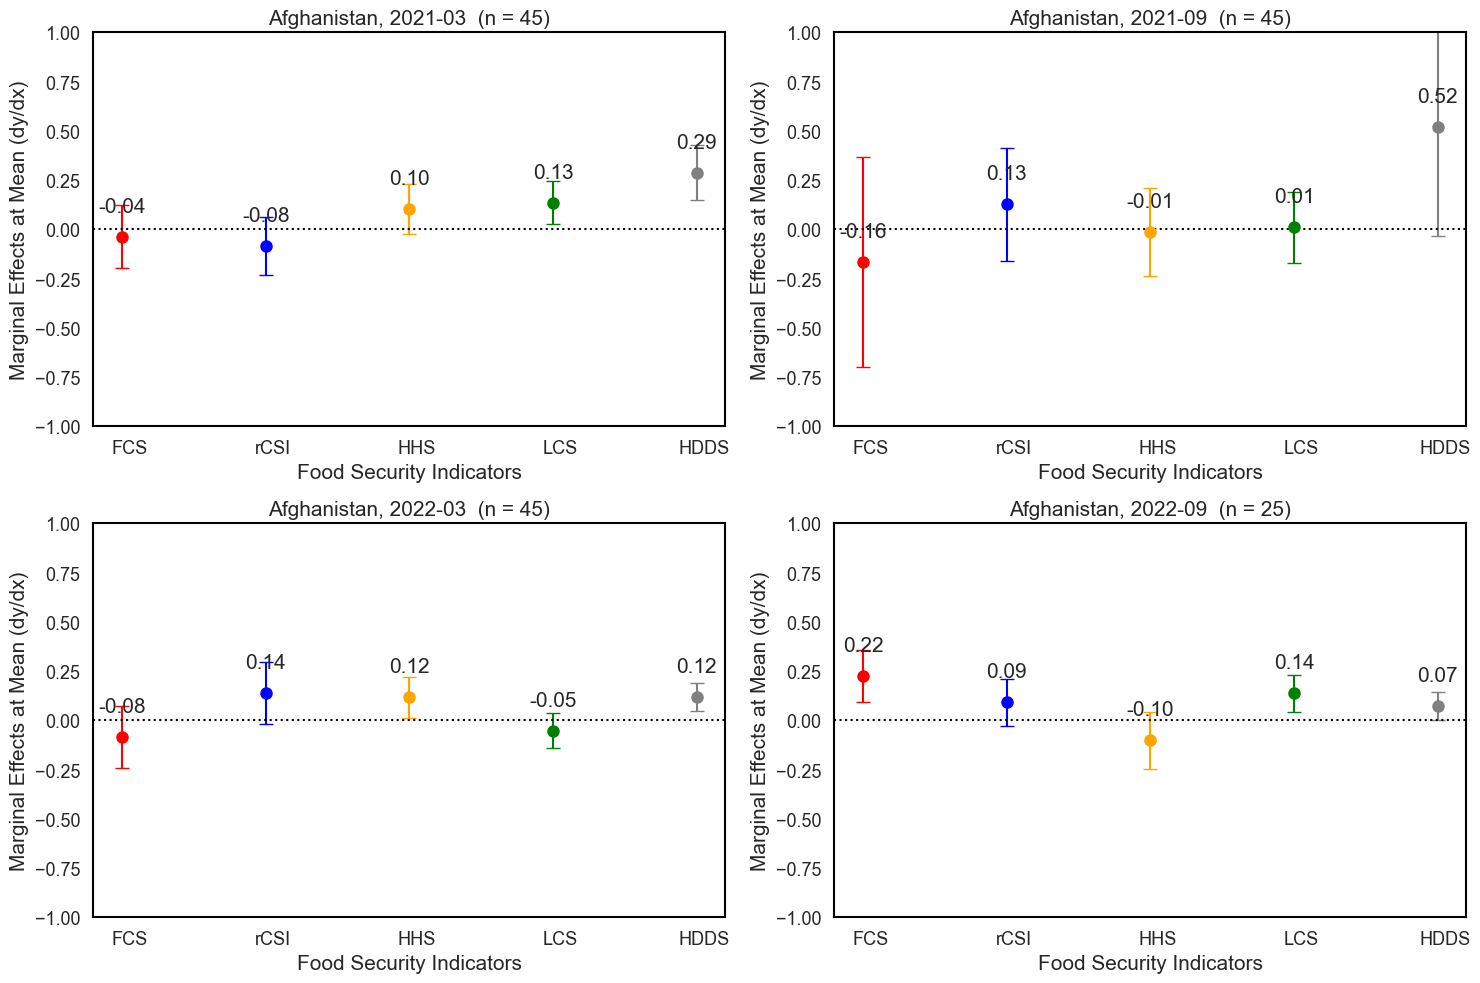

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Initialize figure for 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Variable display map for color and labels
variable_display_map = {
    'FCS_3plus_up': ('FCS', 'red'),
    'rCSI_3plus_up': ('rCSI', 'blue'),
    'hhs_3plus_up': ('HHS', 'orange'),
    'lcs_3plus_up': ('LCS', 'green'),
    'hdds_3plus_up': ('HDDS', 'gray')
}

# Loop through each FSI group
for num, fsi_combi in enumerate(sorted(test_df_sub[test_df_sub['country_name'].isin(['Afghanistan'])]['index'].unique())):
    
    # ---- Phase 3+ Model ----
    reg_df3 = test_df_sub[test_df_sub['index'] == fsi_combi]
    variables3 = combi_match[reg_df3['FSI_combination'].unique()[0]]
    reg_df3 = test_df_sub[test_df_sub['index'] == fsi_combi].dropna(subset=variables3 + ['phase3_plus_up'])
   
    
    y3 = reg_df3['phase3_plus_up']
    X3 = sm.add_constant(reg_df3[variables3])

    model3 = sm.Logit(y3, X3).fit(cov_type='HC1')
    margeff3 = model3.get_margeff(at='mean', method='dydx')
    me_df3 = margeff3.summary_frame()
    effects3 = me_df3['dy/dx'].values
    std_errs3 = me_df3['Std. Err.'].values

    # Get color and label for each variable
    colors = [variable_display_map[var][1] for var in variables3]
    labels = [variable_display_map[var][0] for var in variables3]

    # ---- Color and Label Setup ----
    color_dict = {
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['red', 'blue', 'orange', 'green', 'gray'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'): ['red', 'blue', 'orange', 'green'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['red', 'blue', 'green', 'gray'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'): ['red', 'blue', 'green']
    }

    gca_dict = {
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['FCS', 'rCSI', 'HHS', 'LCS', 'HDDS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'hhs_3plus_up', 'lcs_3plus_up'): ['FCS', 'rCSI', 'HHS', 'LCS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up', 'hdds_3plus_up'): ['FCS', 'rCSI', 'LCS', 'HDDS'],
        ('FCS_3plus_up', 'rCSI_3plus_up', 'lcs_3plus_up'): ['FCS', 'rCSI', 'LCS']
    }

    colors = color_dict.get(tuple(variables3), ['red', 'blue', 'orange', 'green', 'gray'])
    labels = gca_dict.get(tuple(variables3), variables3)

    # ---- Plotting ----
    ax = axs[num]
    width = 0.1

    for i, color in enumerate(colors):
        # Phase 3+ (Circles)
        ax.errorbar(i - width / 2, effects3[i], yerr=1.96 * std_errs3[i],
                    color=color, fmt='o', markersize=8, capsize=5, label="Phase 3+" if i == 0 else "")
        ax.annotate(f'{effects3[i]:.2f}', (i - width / 2, effects3[i]),
                    xytext=(0, 18), textcoords="offset points", ha='center', fontsize=15)
        
        
    ax.set_xticks(range(len(variables3)))
    ax.set_xticklabels(labels, fontsize=14)
    ax.axhline(y=0, color='black', linestyle=':')
    ax.set_ylabel('Marginal Effects at Mean (dy/dx)', fontsize=15)
    ax.set_xlabel('Food Security Indicators', fontsize=15)
    
    country_name, period_name = parse_index_string(fsi_combi)
    ax.set_title(
        f'{country_name}, {period_name}  (n = {len(reg_df3)})',
        fontsize=15
    )
    ax.set_ylim([-1, 1])
    ax.grid(False)

    # Styling
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(13)


# Finalize layout
plt.tight_layout()
plt.show()

## Figure SI.8. Residual Distributions: OLS Regression vs. Fractional Logistic Regression Model

In [40]:
residual_df_ols = []

# Loop through each FSI group
for num, fsi_combi in enumerate(test_df_sub['FSI_combination'].unique()):
    print(fsi_combi)
    
    # Predictors for Phase 3+
    variables3 = combi_match[fsi_combi]

    # Subset and drop missing
    reg_df3 = (
        test_df_sub[test_df_sub['FSI_combination'] == fsi_combi]
        .dropna(subset=variables3 + ['phase3_plus_up'])
        .copy()
    )

    # OLS: y = Xβ + ε
    y3 = reg_df3['phase3_plus_up']
    X3 = sm.add_constant(reg_df3[variables3], has_constant='add')

    ols3 = sm.OLS(y3, X3).fit(cov_type='HC1')  # robust (HC1) like your logit fit
    y_hat = ols3.predict(X3)

    # Residuals (observed - fitted)
    reg_df3['predicted'] = y_hat
    reg_df3['residual'] = reg_df3['phase3_plus_up'] - reg_df3['predicted']

    # Collect columns
    keep_cols = [
        'soundness of method',
        'time realiability',
        'reliability score',
        'RS', 'TS', 'SS',
        'district', 'clean_district', 'yearmon', 'index', 'country_name',
        'phase3_plus_up', 'predicted', 'residual'
    ]
    # Keep only those that exist
    keep_cols = [c for c in keep_cols if c in reg_df3.columns]

    residual_df_ols.append(reg_df3[keep_cols])

residual_analysis_ols = pd.concat(residual_df_ols, ignore_index=True)
residual_analysis_ols


FCS-RCSI-HHS-LCS-HDDS
FCS-RCSI-HHS-LCS
FCS-RCSI-LCS-HDDS
FCS-RCSI-LCS


,soundness of method,time realiability,reliability score,RS,TS,SS,district,clean_district,yearmon,index,country_name,phase3_plus_up,predicted,residual
0,M2,T2,R2,4.0,4.0,4.0,ambovombeandroy,ambovombeandroy,2022-04,"('Madagascar', '2022-04')",Madagascar,0.45,0.463979,-0.013979
1,M2,T2,R2,4.0,4.0,4.0,bekily,bekily,2022-04,"('Madagascar', '2022-04')",Madagascar,0.55,0.532897,0.017103
2,M2,T2,R2,4.0,4.0,4.0,beloha,beloha,2022-04,"('Madagascar', '2022-04')",Madagascar,0.40,0.409795,-0.009795
3,M2,T2,R2,4.0,4.0,4.0,tsihombe,tsihombe,2022-04,"('Madagascar', '2022-04')",Madagascar,0.30,0.364405,-0.064405
4,M2,T2,R2,4.0,4.0,4.0,amboasaryatsimo,amboasaryatsimo,2022-04,"('Madagascar', '2022-04')",Madagascar,0.40,0.487204,-0.087204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,M1,T2,R1+,3.0,4.0,2.0,wadisalih,wadisalih,2021-04,"('Sudan', '2021-04')",Sudan,0.15,0.134830,0.015170
1689,M1,T2,R1+,3.0,4.0,2.0,wasatalgedaref,wasatalgedaref,2021-04,"('Sudan', '2021-04')",Sudan,0.25,0.152872,0.097128
1690,M1,T2,R1+,3.0,4.0,2.0,wasatjabalmarrah,wasatjabalmarrah,2021-04,"('Sudan', '2021-04')",Sudan,0.25,0.247463,0.002537
1691,M1,T2,R1+,3.0,4.0,2.0,yassin,yassin,2021-04,"('Sudan', '2021-04')",Sudan,0.25,0.128529,0.121471


In [41]:
# figure for 2x2 subplots

residual_df =[]

# variable map for color and labels
variable_display_map = {
    'FCS_3plus_up': ('FCS', 'red'),
    'rCSI_3plus_up': ('rCSI', 'blue'),
    'hhs_3plus_up': ('HHS', 'orange'),
    'lcs_3plus_up': ('LCS', 'green'),
    'hdds_3plus_up': ('HDDS', 'gray')
}

# Loop through each FSI group
for num, fsi_combi in enumerate(test_df_sub['FSI_combination'].unique()):
    print(fsi_combi)
    
    # get predictor sets
    variables3 = combi_match[fsi_combi]
    variables4 = combi_match4[fsi_combi]

    # ---- Phase 3+ Model ----
    reg_df3 = test_df_sub[test_df_sub['FSI_combination'] == fsi_combi].dropna(subset=variables3 + ['phase3_plus_up'])
    y3 = reg_df3['phase3_plus_up']
    X3 = sm.add_constant(reg_df3[variables3])

    model3 = sm.Logit(y3, X3).fit(cov_type='HC1')
    
    # predicted probabilities
    y_pred = model3.predict(X3)

    # residuals (observed - predicted)
    residuals = y3 - y_pred
    
    # store in the dataframe for further analysis
    reg_df3['predicted'] = y_pred
    reg_df3['residual'] = residuals
    
    residual_df.append(reg_df3[['soundness of method',
                                 'time realiability',
                                 'reliability score',
                                 'RS',
                                 'TS',
                                 'SS']+['district','clean_district','yearmon','index','country_name','phase3_plus_up','predicted','residual']])
    

residual_analysis = pd.concat(residual_df)
residual_analysis

FCS-RCSI-HHS-LCS-HDDS
Optimization terminated successfully.
         Current function value: 0.644149
         Iterations 4
FCS-RCSI-HHS-LCS
Optimization terminated successfully.
         Current function value: 0.580934
         Iterations 5
FCS-RCSI-LCS-HDDS
Optimization terminated successfully.
         Current function value: 0.392468
         Iterations 6
FCS-RCSI-LCS
Optimization terminated successfully.
         Current function value: 0.381863
         Iterations 6


,soundness of method,time realiability,reliability score,RS,TS,SS,district,clean_district,yearmon,index,country_name,phase3_plus_up,predicted,residual
0,M2,T2,R2,4.0,4.0,4.0,ambovombeandroy,ambovombeandroy,2022-04,"('Madagascar', '2022-04')",Madagascar,0.45,0.462249,-0.012249
1,M2,T2,R2,4.0,4.0,4.0,bekily,bekily,2022-04,"('Madagascar', '2022-04')",Madagascar,0.55,0.534404,0.015596
2,M2,T2,R2,4.0,4.0,4.0,beloha,beloha,2022-04,"('Madagascar', '2022-04')",Madagascar,0.40,0.407095,-0.007095
3,M2,T2,R2,4.0,4.0,4.0,tsihombe,tsihombe,2022-04,"('Madagascar', '2022-04')",Madagascar,0.30,0.362898,-0.062898
4,M2,T2,R2,4.0,4.0,4.0,amboasaryatsimo,amboasaryatsimo,2022-04,"('Madagascar', '2022-04')",Madagascar,0.40,0.486540,-0.086540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,M1,T2,R1+,3.0,4.0,2.0,wadisalih,wadisalih,2021-04,"('Sudan', '2021-04')",Sudan,0.15,0.141651,0.008349
1845,M1,T2,R1+,3.0,4.0,2.0,wasatalgedaref,wasatalgedaref,2021-04,"('Sudan', '2021-04')",Sudan,0.25,0.154740,0.095260
1846,M1,T2,R1+,3.0,4.0,2.0,wasatjabalmarrah,wasatjabalmarrah,2021-04,"('Sudan', '2021-04')",Sudan,0.25,0.242842,0.007158
1847,M1,T2,R1+,3.0,4.0,2.0,yassin,yassin,2021-04,"('Sudan', '2021-04')",Sudan,0.25,0.134815,0.115185


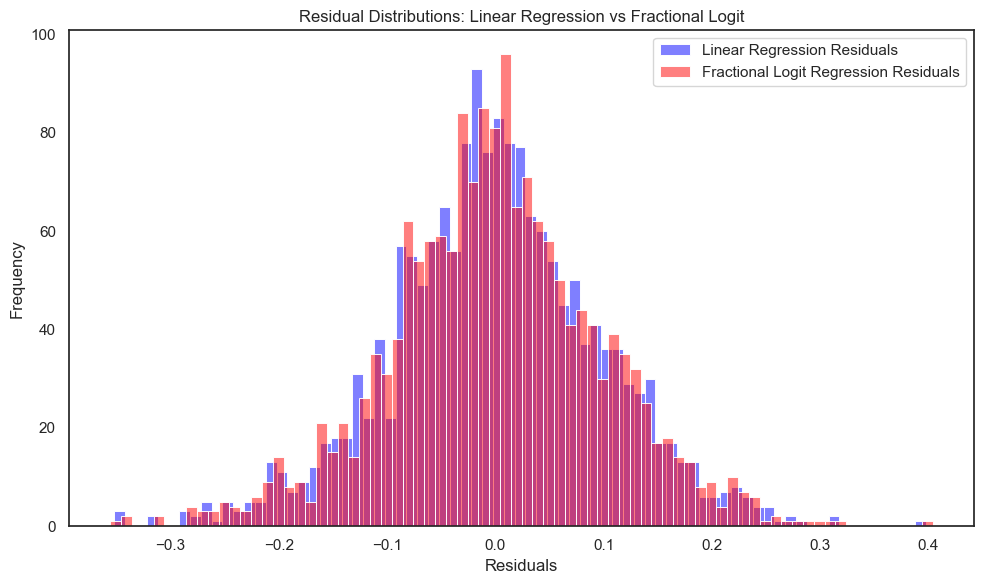

In [42]:
plt.figure(figsize=(10, 6))

# OLS residuals
sns.histplot(
    residual_analysis_ols['residual'],
    binwidth=0.01,
    color='blue',
    label='Linear Regression Residuals',
    alpha=0.5
)

# Fractional logit residuals
sns.histplot(
    residual_analysis['residual'],
    binwidth=0.01,
    color='red',
    label='Fractional Logit Regression Residuals',
    alpha=0.5
)

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distributions: Linear Regression vs Fractional Logit')
plt.legend()
plt.tight_layout()
plt.show()


## Table SI.4. Explained variation (R2) in consensus-based phase 3+ estimates across OLS model specifications, by data group

### Raw R^2

In [43]:
import statsmodels.formula.api as smf
# Unique countries across all groups
unique_countries = sorted(test_df_sub['country'].unique())
country_marker_map = {country: marker for country, marker in zip(unique_countries, ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>', '1', '2', '3', '4', 'h'])}

# Store R-squared results
r_squared_results = []

for num in range(4):
    fsi_combi = test_df_sub['FSI_combination'].unique()[num]

    # filter and prepare the data
    reg_df = test_df_sub[test_df_sub['FSI_combination'] == fsi_combi].dropna(subset=combi_match[fsi_combi]).copy()
    print(len(reg_df))
    
    # clean country names
    reg_df['clean_country'] = reg_df['country'].str.replace(" ", "_").str.replace("-", "_")
    reg_df['country'] = reg_df['country'].astype('category')

    # create formula for interaction model
    base_terms = combi_match[fsi_combi]  # FSI variables
    country_fe = "C(country)"  # Country fixed effects with reference
    interaction_terms = [f'{fsi}:C(country)' for fsi in combi_match[fsi_combi]]
    
    formula1 = 'phase3_plus_up ~ ' + ' + '.join(base_terms)
    formula2 = 'phase3_plus_up ~ ' + ' + '.join(base_terms + [country_fe])
    formula3 = 'phase3_plus_up ~ ' + ' + '.join(base_terms + [country_fe] + interaction_terms)
    
    print('Model 1 (FSI Only):', formula1)
    print('Model 2 (FSI + Country FE:', formula2)
    print('Model 3 (FSI + Country FE + FSI*Country):', formula3)
    
    
    # Fit the OLS models
    model1 = smf.ols(formula1, data=reg_df).fit(cov_type = 'HC1')
    model2 = smf.ols(formula2, data=reg_df).fit(cov_type = 'HC1')
    model3 = smf.ols(formula3, data=reg_df).fit(cov_type = 'HC1')
    
    # Store R-squared values
    r_squared_results.append({
        "FSI_Group": fsi_combi,
        "FSI_Only_R2": model1.rsquared.round(3),
        "FSI_Country_FE_R2": model2.rsquared.round(3),
        "Fully_Interacted_R2": model3.rsquared.round(3)
    })
    
# Convert R-squared results to DataFrame and display
r_squared_df = pd.DataFrame(r_squared_results)
r_squared_df


600
Model 1 (FSI Only): phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + hdds_3plus_up
Model 2 (FSI + Country FE: phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + hdds_3plus_up + C(country)
Model 3 (FSI + Country FE + FSI*Country): phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + hdds_3plus_up + C(country) + FCS_3plus_up:C(country) + rCSI_3plus_up:C(country) + hhs_3plus_up:C(country) + lcs_3plus_up:C(country) + hdds_3plus_up:C(country)
360
Model 1 (FSI Only): phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up
Model 2 (FSI + Country FE: phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + C(country)
Model 3 (FSI + Country FE + FSI*Country): phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + C(country) + FCS_3plus_up:C(country) + rCSI_3plus_up:C(country) + hhs_3plus_up:C(country) + lcs_3plus_up:C(country)
236
Model 1 (FSI Only

,FSI_Group,FSI_Only_R2,FSI_Country_FE_R2,Fully_Interacted_R2
0,FCS-RCSI-HHS-LCS-HDDS,0.370,0.589,0.649
1,FCS-RCSI-HHS-LCS,0.589,0.636,0.641
2,FCS-RCSI-LCS-HDDS,0.555,0.573,0.603
3,FCS-RCSI-LCS,0.479,0.518,0.565


### Adjusted R^2

In [44]:
# Unique countries across all groups
unique_countries = sorted(test_df_sub['country'].unique())
country_marker_map = {country: marker for country, marker in zip(unique_countries, ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>', '1', '2', '3', '4', 'h'])}

# store R-squared results
r_squared_results = []

for num in range(4):
    fsi_combi = test_df_sub['FSI_combination'].unique()[num]

    # Filter and prepare the data
    reg_df = test_df_sub[test_df_sub['FSI_combination'] == fsi_combi].dropna(subset=combi_match[fsi_combi]).copy()
    print(len(reg_df))
    # Sanitize country names
    reg_df['clean_country'] = reg_df['country'].str.replace(" ", "_").str.replace("-", "_")
    reg_df['country'] = reg_df['country'].astype('category')

    # Create the formula for interaction model
    base_terms = combi_match[fsi_combi]  # FSI variables
    country_fe = "C(country)"  # Country fixed effects with reference
    interaction_terms = [f'{fsi}:C(country)' for fsi in combi_match[fsi_combi]]
    
    formula1 = 'phase3_plus_up ~ ' + ' + '.join(base_terms)
    formula2 = 'phase3_plus_up ~ ' + ' + '.join(base_terms + [country_fe])
    formula3 = 'phase3_plus_up ~ ' + ' + '.join(base_terms + [country_fe] + interaction_terms)
    
    print('Model 1 (FSI Only):', formula1)
    print('Model 2 (FSI + Country FE:', formula2)
    print('Model 3 (FSI + Country FE + FSI*Country):', formula3)
    
    
    # Fit the OLS models
    model1 = smf.ols(formula1, data=reg_df).fit(cov_type = 'HC1')
    model2 = smf.ols(formula2, data=reg_df).fit(cov_type = 'HC1')
    model3 = smf.ols(formula3, data=reg_df).fit(cov_type = 'HC1')
    
    
    # Store R-squared values
    r_squared_results.append({
        "FSI_Group": fsi_combi,
        "FSI_Only_R2": model1.rsquared_adj.round(3),
        "FSI_Country_FE_R2": model2.rsquared_adj.round(3),
        "Fully_Interacted_R2": model3.rsquared_adj.round(3)
    })   


# Convert R-squared results to DataFrame and display
r_squared_df = pd.DataFrame(r_squared_results)
r_squared_df


600
Model 1 (FSI Only): phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + hdds_3plus_up
Model 2 (FSI + Country FE: phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + hdds_3plus_up + C(country)
Model 3 (FSI + Country FE + FSI*Country): phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + hdds_3plus_up + C(country) + FCS_3plus_up:C(country) + rCSI_3plus_up:C(country) + hhs_3plus_up:C(country) + lcs_3plus_up:C(country) + hdds_3plus_up:C(country)
360
Model 1 (FSI Only): phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up
Model 2 (FSI + Country FE: phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + C(country)
Model 3 (FSI + Country FE + FSI*Country): phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + C(country) + FCS_3plus_up:C(country) + rCSI_3plus_up:C(country) + hhs_3plus_up:C(country) + lcs_3plus_up:C(country)
236
Model 1 (FSI Only

,FSI_Group,FSI_Only_R2,FSI_Country_FE_R2,Fully_Interacted_R2
0,FCS-RCSI-HHS-LCS-HDDS,0.365,0.582,0.627
1,FCS-RCSI-HHS-LCS,0.584,0.630,0.626
2,FCS-RCSI-LCS-HDDS,0.547,0.560,0.568
3,FCS-RCSI-LCS,0.476,0.512,0.548


## Figure SI.10. ANOVA decomposition of explained source of variation, by data group

phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + hdds_3plus_up + C(country) + FCS_3plus_up:C(country) + rCSI_3plus_up:C(country) + hhs_3plus_up:C(country) + lcs_3plus_up:C(country) + hdds_3plus_up:C(country)
phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + hhs_3plus_up + lcs_3plus_up + C(country) + FCS_3plus_up:C(country) + rCSI_3plus_up:C(country) + hhs_3plus_up:C(country) + lcs_3plus_up:C(country)
phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + lcs_3plus_up + hdds_3plus_up + C(country) + FCS_3plus_up:C(country) + rCSI_3plus_up:C(country) + lcs_3plus_up:C(country) + hdds_3plus_up:C(country)
phase3_plus_up ~ FCS_3plus_up + rCSI_3plus_up + lcs_3plus_up + C(country) + FCS_3plus_up:C(country) + rCSI_3plus_up:C(country) + lcs_3plus_up:C(country)


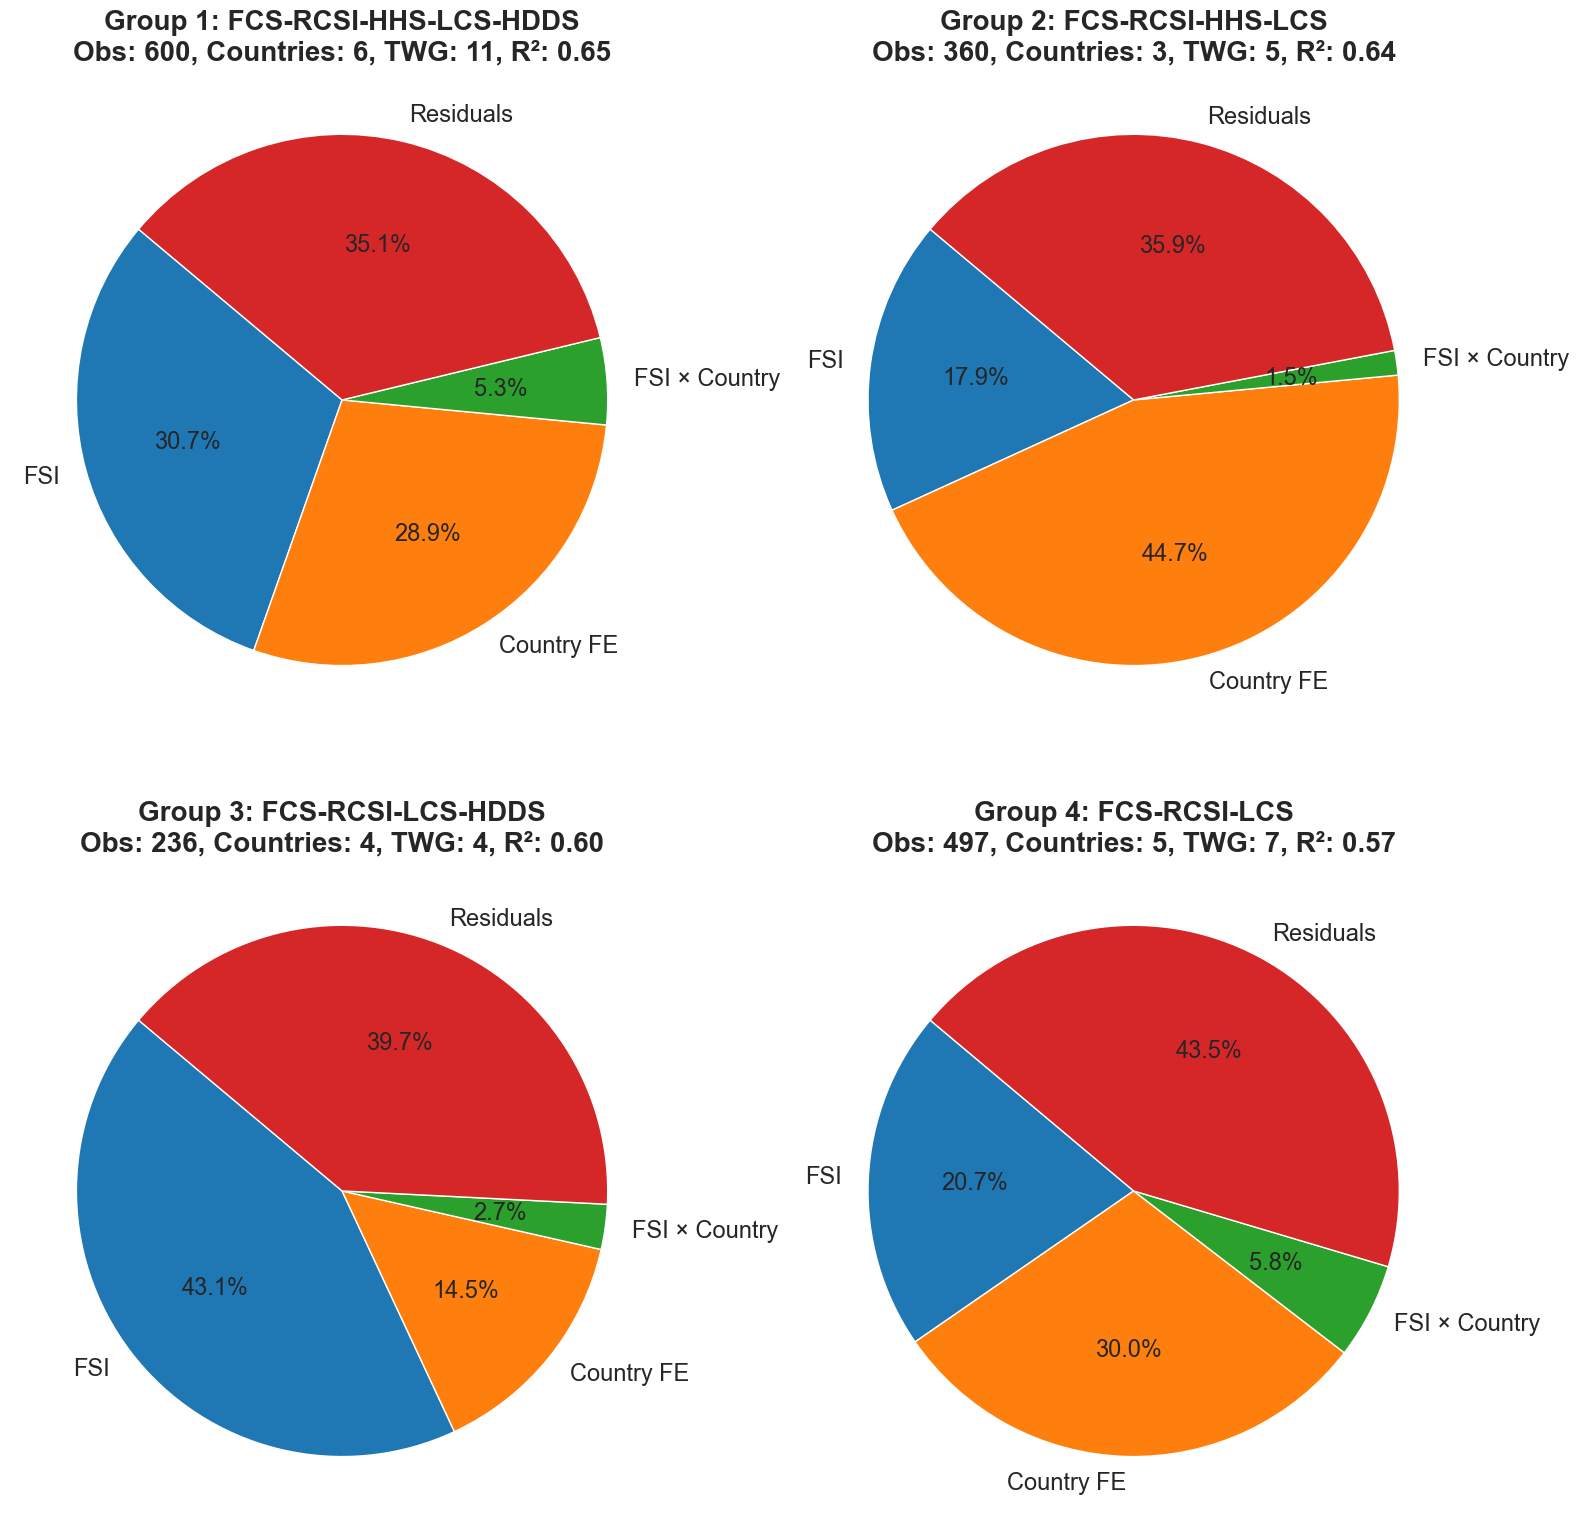

In [45]:
# Initialize results list
result_df = []

# Create 2x2 figure for pie charts
fig, axs = plt.subplots(2, 2, figsize=(16, 16))  
axs = axs.flatten()  # Flatten to access as a list

for num in range(4):
    fsi_combi = test_df['FSI_combination'].unique()[num]

    # filter and clean the dataset
    reg_df = test_df[test_df['FSI_combination'] == fsi_combi].dropna(subset=combi_match[fsi_combi]).copy()
    reg_df['country'] = reg_df['country'].replace({'DR Congo': 'DRC'})
    reg_df['country'] = reg_df['country'].astype('category')

    # Define regression formula
    base_terms = combi_match[fsi_combi]  
    country_fe = "C(country)"  
    interaction_terms = [f'{fsi}:C(country)' for fsi in combi_match[fsi_combi]]
    formula = 'phase3_plus_up ~ ' + ' + '.join(base_terms + [country_fe] + interaction_terms)
    print(formula)
    
    # Fit OLS model
    model = smf.ols(formula, data=reg_df).fit(cov = 'HC1')

    # Get ANOVA decomposition
    anova_table = sm.stats.anova_lm(model, typ=1)  
    anova_table['Percent_Variance'] = (anova_table['sum_sq'] / anova_table['sum_sq'].sum()) * 100
    #print(anova_table)
    # Extract sum of squares for each component
    fsi_vars = combi_match[fsi_combi]  
    interaction_vars = [f'{fsi}:C(country)' for fsi in fsi_vars]

    # Extract sum of squares
    total_ss = anova_table['sum_sq'].sum()
    fsi_var_ss = anova_table.loc[fsi_vars, 'sum_sq'].sum() if set(fsi_vars).issubset(anova_table.index) else 0
    country_ss = anova_table.loc['C(country)', 'sum_sq'] if 'C(country)' in anova_table.index else 0
    interaction_ss = anova_table.loc[interaction_vars, 'sum_sq'].sum() if set(interaction_vars).issubset(anova_table.index) else 0
    residual_ss = anova_table.loc['Residual', 'sum_sq'] if 'Residual' in anova_table.index else 0

    # compute variance proportions
    fsi_pct = (fsi_var_ss / total_ss) * 100 if total_ss > 0 else 0
    country_pct = (country_ss / total_ss) * 100 if total_ss > 0 else 0
    interaction_pct = (interaction_ss / total_ss) * 100 if total_ss > 0 else 0
    residual_pct = (residual_ss / total_ss) * 100 if total_ss > 0 else 0

    # approximate variance explained by intercept
    constant_var = model.params[0] ** 2 if 0 in model.params else 0  
    constant_pct = (constant_var / total_ss) * 100 if total_ss > 0 else 0

    # compute "Others" category (ensure non-negative)
    others_pct = max(0, 100 - (fsi_pct + country_pct + interaction_pct + constant_pct + residual_pct))

    # ensure all values sum exactly to 100% (redistribute minor rounding errors)
    total_sum = fsi_pct + country_pct + interaction_pct + constant_pct + residual_pct + others_pct
    if total_sum != 100:
        scale_factor = 100 / total_sum
        fsi_pct *= scale_factor
        country_pct *= scale_factor
        interaction_pct *= scale_factor
        constant_pct *= scale_factor
        residual_pct *= scale_factor
        others_pct *= scale_factor

    # Other model details
    num_observations = len(reg_df)
    num_countries = reg_df['country'].nunique()
    num_twg = reg_df['index'].nunique()  # Assuming `index` represents TWG analyses
    r_squared = model.rsquared

    # store variance decomposition results
    variance_decomp = {
        'Group': f'Group {num+1}: {fsi_combi}',
        'Observations': num_observations,
        'R-Squared': r_squared,
        'Unique Countries': num_countries,
        'Unique TWG Analyses': num_twg,
        'FSI (%)': fsi_pct,
        'Country Fixed Effects (%)': country_pct,
        'FSI × Country Interactions (%)': interaction_pct,
        'Constant (%)': constant_pct,
        'Residuals (%)': residual_pct,
#        'Others (%)': others_pct
    }
    result_df.append(variance_decomp)

    # Pie chart labels and values
    labels = ['FSI', 'Country FE', 'FSI × Country', 'Residuals']
    values = [fsi_pct, country_pct, interaction_pct, residual_pct]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728']  # Distinct colors

    # Create pie chart
    axs[num].pie(
        values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, textprops={'fontsize': 17}
    )

    # Set subplot title with additional model info
    axs[num].set_title(
        f'Group {num+1}: {fsi_combi}\n'
        f'Obs: {num_observations}, Countries: {num_countries}, TWG: {num_twg}, R²: {r_squared:.2f}',
        fontsize=20, fontweight='bold'
    )

# adjust layout and show result figure
plt.tight_layout()
plt.show()



## Figure SI.11: Effects of conflict and price factors on residual fraction of consensus-based 3+ population predicted by fractional logit model

In [46]:
# Load IPC-price-acled linked data for Afghanistan, Haiti, and Kenya
ipc_price_acled_afg = pd.read_csv(home + r'\ipc_consistency_paper\stores\ipc_price_acled_afg.csv')
ipc_price_acled_haiti = pd.read_csv(home + r'\ipc_consistency_paper\stores\ipc_price_acled_haiti.csv')
ipc_price_acled_kenya = pd.read_csv(home + r'\ipc_consistency_paper\stores\ipc_price_acled_kenya.csv')

price_acled_df = pd.concat([ipc_price_acled_afg, ipc_price_acled_haiti, ipc_price_acled_kenya])
price_acled_df['yearmon'] = pd.to_datetime(price_acled_df['yearmon'])
price_acled_df.head()

,Unnamed: 0,analysis_id,yearmon,country_name,unique_name,population,estimated_population,p3plus,p3plus_percentage,overall_phase,...,inflation_food_price_index_above_1sd,inflation_food_price_index_above_2sd,zscore_anomaly,anomaly_above_1sd,anomaly_below_1sd,anomaly_above_2sd,anomaly_below_2sd,percent_deviation,percent_deviation_rolling_mean_6,zscore_anomaly.1
0,0,24380569,2021-09-01,Afghanistan,Afghanistan_2021-09,41727304,949721,474860.0,0.50,3.0,...,1.0,1.0,0.328993,0.0,0.0,0.0,0.0,1.012036,-0.610044,0.328993
1,1,24380569,2021-09-01,Afghanistan,Afghanistan_2021-09,41727304,218763,76567.0,0.35,3.0,...,1.0,1.0,0.112783,0.0,0.0,0.0,0.0,0.353537,-0.765189,0.112783
2,2,24380569,2021-09-01,Afghanistan,Afghanistan_2021-09,41727304,494813,247407.0,0.50,3.0,...,0.0,0.0,0.279288,0.0,0.0,0.0,0.0,1.150795,0.383247,0.279288
3,3,24380569,2021-09-01,Afghanistan,Afghanistan_2021-09,41727304,787829,315132.0,0.40,3.0,...,0.0,0.0,-0.015527,0.0,0.0,0.0,0.0,-0.048298,0.393506,-0.015527
4,4,24380569,2021-09-01,Afghanistan,Afghanistan_2021-09,41727304,819460,245838.0,0.30,3.0,...,0.0,0.0,-0.025734,0.0,0.0,0.0,0.0,-0.094520,-0.491119,-0.025734


In [47]:
country_name_map = {
    'Congo': 'Democratic Republic of the Congo',
    'Sudan': 'Sudan',
    'CAR': 'Central African Republic',
    'Yemen': 'Yemen',
    'Afghanistan': 'Afghanistan',
    'South Sudan': 'South Sudan',
    'Mozambique': 'Mozambique',
    'Haiti': 'Haiti',
    'Lebanon': 'Lebanon',
    'Madagascar': 'Madagascar',
    'Kenya': 'Kenya',
    'Pakistan': 'Pakistan',
    }


In [48]:
#Subset TEEST_DF
sub_test_df = test_df[test_df['country_name'].isin(['Kenya','Haiti','Afghanistan'])]
sub_test_df['yearmon'] = pd.to_datetime(sub_test_df['yearmon'])
standardized_region_map = {
    # Kenya
    'baringo': 'Baringo',
    'embu': 'Embu',
    'garissa': 'Garissa',
    'isiolo': 'Isiolo',
    'kajiado': 'Kajiado',
    'kilifi': 'Kilifi',
    'kitui': 'Kitui',
    'kwale': 'Kwale',
    'laikipia': 'Laikipia',
    'lamucounty': 'Lamu',
    'makueni': 'Makueni',
    'mandera': 'Mandera',
    'marsabit': 'Marsabit',
    'meru': 'Meru',
    'narok': 'Narok',
    'nyeri': 'Nyeri',
    'samburu': 'Samburu',
    'taita': 'Taita Taveta',
    'TANA RIVER': 'Tana River',
    'tharaka': 'Tharaka-Nithi',
    'turkana': 'Turkana',
    'wajir': 'Wajir',
    'westpokot': 'West Pokot',

    # Haiti (IPC-style names to standard departments)
    'artibonite_ht01': 'Artibonite',
    'artiboniteht03': 'Artibonite',
    'artiboniteht04': 'Artibonite',
    'basplateauht03': 'Centre',
    'carrefour_p+tp': 'Ouest',
    'citesoleilp_tp': 'Ouest',
    'croixdebouquetp+tp': 'Ouest',
    'Delmas P+TP': 'Ouest',
    'grandeanseht07': 'Grande-Anse',
    'grandeanseht08': 'Grande-Anse',
    'hautplateauht03': 'Centre',
    'nippesht01': 'Nippes',
    'nippesht07': 'Nippes',
    'nordht02': 'Nord',
    'nordht03': 'Nord',
    'nordestht02': 'Nord-Est',
    'nordouestht01': 'Nord-Ouest',
    'nordouestht02': 'Nord-Ouest',
    'ouest_ht01lagonave': 'Ouest',
    'ouestht05': 'Ouest',
    'ouestht06': 'Ouest',
    'ouestht07': 'Ouest',
    'petionvillep+tp': 'Ouest',
    'portauprincep+tp': 'Ouest',
    'sudht01': 'Sud',
    'sudht07': 'Sud',
    'sudht08': 'Sud',
    'sudestht01': 'Sud-Est',
    'sudestht07': 'Sud-Est',
    'tabarrep+tp': 'Ouest',
    'villedejeremie': 'Grande-Anse',
    'villedescayes': 'Sud',

    # Afghanistan
    'badakhshan': 'Badakhshan',
    'badghis': 'Badghis',
    'baghlan': 'Baghlan',
    'balkh': 'Balkh',
    'bamyan': 'Bamyan',
    'daykundi': 'Daykundi',
    'farah': 'Farah',
    'faryab': 'Faryab',
    'ghazni': 'Ghazni',
    'ghor': 'Ghor',
    'hilmand': 'Helmand',
    'hirat': 'Herat',
    'jawzjan': 'Jowzjan',
    'kabul': 'Kabul',
    'kandahar': 'Kandahar',
    'kapisa': 'Kapisa',
    'khost': 'Khost',
    'kunar': 'Kunar',
    'kunduz': 'Kunduz',
    'laghman': 'Laghman',
    'logar': 'Logar',
    'nangarhar': 'Nangarhar',
    'nimroz': 'Nimruz',
    'nuristan': 'Nuristan',
    'paktika': 'Paktika',
    'paktya': 'Paktia',
    'panjsher': 'Panjshir',
    'parwan': 'Parwan',
    'samangan': 'Samangan',
    'sarepul': 'Sar-e Pol',
    'takhar': 'Takhar',
    'uruzgan': 'Urozgan',
    'wardak': 'Wardak',
    'zabul': 'Zabul'
}

sub_test_df['region'] = sub_test_df['clean_district'].map(standardized_region_map)

In [49]:
sub_test_df.groupby('country_name')['yearmon'].value_counts()

country_name  yearmon   
Afghanistan   2021-03-01    45
              2021-09-01    45
              2022-03-01    45
              2022-09-01    45
Haiti         2021-09-01    32
Kenya         2021-02-01    23
              2021-09-01    23
Name: yearmon, dtype: int64

In [50]:
price_acled_df.loc[
    price_acled_df['yearmon'] == pd.to_datetime('2021-07-01'),
    'yearmon'
] = pd.to_datetime('2021-09-01')

price_acled_df.groupby('country_name')['yearmon'].value_counts()

country_name  yearmon   
Afghanistan   2021-03-01    34
              2021-09-01    34
              2022-03-01    34
              2022-09-01    34
Haiti         2021-09-01    32
              2022-09-01    32
Kenya         2021-02-01    23
              2021-09-01    23
              2022-02-01    23
              2022-07-01    23
Name: yearmon, dtype: int64

In [51]:
base_col =['region','yearmon','clean_district','FSI_combination','country']
fsi_indicator = ['phase3_plus_up',
 'FCS_3plus_up',
 'rCSI_3plus_up',
 'hhs_3plus_up',
 'lcs_3plus_up',
 'hdds_3plus_up']

final_sub_test_df = sub_test_df[sub_test_df['U-R']!='Urban'][fsi_indicator+base_col].merge(price_acled_df, on = ['region','yearmon'], how = 'left').drop_duplicates(subset=['country_name','clean_district','region','yearmon'])

46
30
Kenya - n = 30
32
30
Haiti - n = 30
136
126
Afghanistan - n = 126


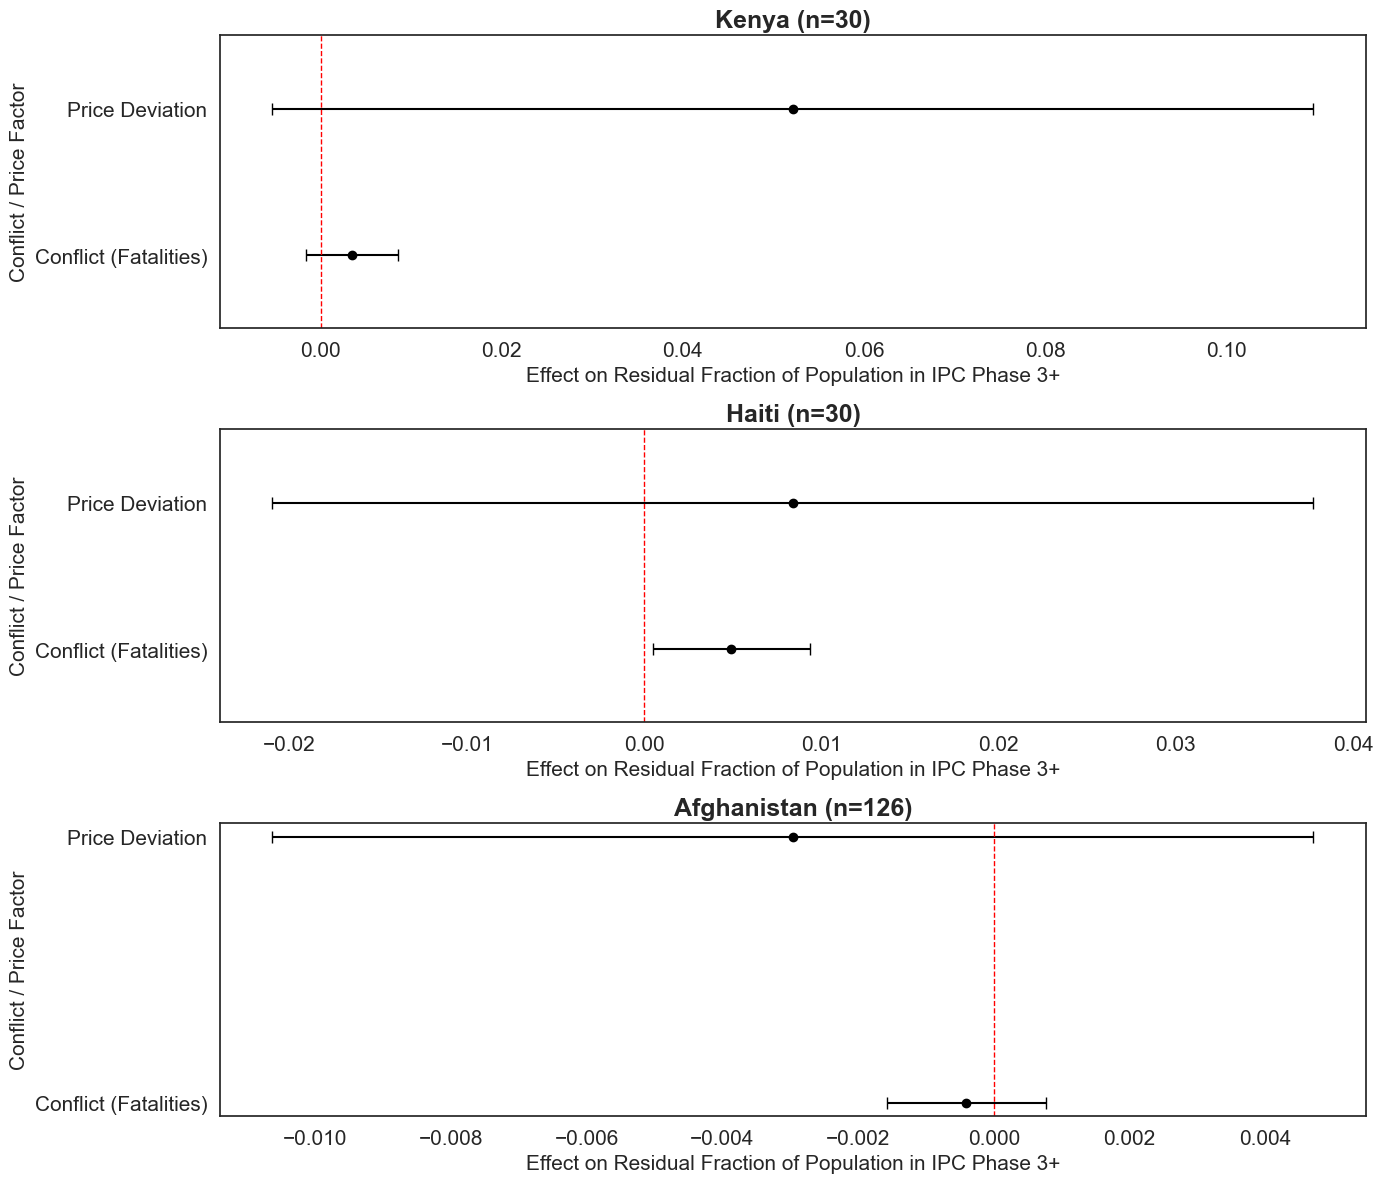

In [52]:
# Define factors
conflict_factors = ['fatalities_total_RSI_rolling_mean_6']
price_factors = ['percent_deviation_rolling_mean_6']

# Friendly labels
label_map = {
    'fatalities_total_RSI_rolling_mean_6': 'Conflict (Fatalities)',
    'percent_deviation_rolling_mean_6': 'Price Deviation'
}

fig, axs = plt.subplots(3, 1, figsize=(14, 12))
axs = axs.flatten()

for i, country in enumerate(final_sub_test_df['country'].unique()[:3]):
    fsi_combi = final_sub_test_df.loc[final_sub_test_df['country'] == country, 'FSI_combination'].iloc[0]
    indicators = combi_match[fsi_combi]

    # Subset & drop missing
    reg_dff = final_sub_test_df[final_sub_test_df['country'] == country]
    
    print(len(reg_dff))
    needed_cols = ['phase3_plus_up'] + indicators + conflict_factors + price_factors
    reg_df = reg_dff[needed_cols].dropna().copy()
    
    print(len(reg_df))
    # Ensure all needed columns are numeric and in [0,1] where applicable
    for col in ['phase3_plus_up'] + indicators:
        reg_df[col] = pd.to_numeric(reg_df[col], errors='coerce')


    print(f"{country} - n = {len(reg_df)}")

    # Fractional logit (GLM Binomial-logit) with HC1 -----
    X_base = sm.add_constant(reg_df[indicators], has_constant='add')
    y_base = reg_df['phase3_plus_up']
    glm_binom = sm.GLM(y_base, X_base, family=sm.families.Binomial())
    model_base = glm_binom.fit(cov_type='HC1')

    p_hat = model_base.predict(X_base)     # predicted probability in [0,1]
    resid_prob = y_base - p_hat            # residual probability (pp)

    # OLS on residual probability with HC1 -----
    X_resid = sm.add_constant(reg_df[conflict_factors + price_factors], has_constant='add')
    model_resid = sm.OLS(resid_prob, X_resid).fit(cov_type='HC1')

    # Effects are already percentage-point effects on residual probability
    params = model_resid.params.drop('const', errors='ignore')
    se = model_resid.bse.drop('const', errors='ignore')
    z = 1.96
    ci_lower = params - z * se
    ci_upper = params + z * se
    
    n_labels = len(params)
    ax.set_ylim(-0.5, n_labels - 0.5)  # Adds padding above and below the bars

    # Plot dot-and-whisker
    ax = axs[i]
    ylabels = [label_map.get(v, v) for v in params.index]
    ax.errorbar(
        x=params.values,
        y=ylabels,
        xerr=[params.values - ci_lower.values, ci_upper.values - params.values],
        fmt='o', color='black', capsize=4
    )
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
    ax.set_title(f"{country} (n={len(reg_df)})", fontsize=18, fontweight='bold')
    ax.set_xlabel("Effect on Residual Fraction of Population in IPC Phase 3+", fontsize=15)
    ax.set_ylabel("Conflict / Price Factor", fontsize=15)
    ax.grid(False, axis='x')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout()
plt.show()


## Table SI.5. Effect of data timeliness and method reliability on residuals from fractional logit model

In [53]:
# ensure both are categorical and create dummies
residual_analysis['country'] = residual_analysis['country_name'].astype('category')
residual_analysis['R2'] = np.where(residual_analysis['RS'] == 4, 1, 0)
residual_analysis['T2'] = np.where(residual_analysis['TS'] == 4, 1, 0)
residual_analysis['S2'] = np.where(residual_analysis['SS'] == 4, 1, 0)

# Fit model
model = smf.ols('residual ~T2 + S2 + C(country)', data=residual_analysis).fit()

# apply robust standard errors (HC1)
robust_model = model.get_robustcov_results(cov_type='HC1')
print(robust_model.summary())

# extract variable names from the model object
var_names = model.model.exog_names  

# create DataFrame with robust results
results_df = pd.DataFrame({
    "Variable": var_names,
    "Coefficient": robust_model.params,
    "Robust SE": robust_model.bse,
    "t-stat": robust_model.tvalues,
    "P-value": robust_model.pvalues
})

                            OLS Regression Results                            
Dep. Variable:               residual   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     16.59
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           2.91e-36
Time:                        20:24:17   Log-Likelihood:                 1571.3
No. Observations:                1643   AIC:                            -3115.
Df Residuals:                    1629   BIC:                            -3039.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------